# Тема: Основы машинного обучения

# Проект: Прогнозирование вероятности оттока пользователей сети фитнес-центров. Разработка плана действий по удержанию клиентов.

**Задача:**
    
Провести анализ электронных анкет и подготовить план действий по удержанию клиентов.



**Цели:**

* Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

* Проанализировать основные признаки, наиболее сильно влияющие на отток;

* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.
    

## Загрузка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install seaborn

In [3]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
# дополнительные настройки для визуализации графиков
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('ggplot')
plt.rc('figure', figsize=(15, 5))

In [5]:
# сохраним данные в переменную
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('C:/Users/Natalika/Desktop/jupyter/projects/gym_churn.csv')

Получим общую информацию о данных.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Выведем первые 10 строк таблицы.

In [7]:
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Набор данных включает следующие поля:
    
    
**Данные клиента за предыдущий до проверки факта оттока месяц:**
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).


**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

### Выводы

* В файле 14 колонок, в каждой из которых по 4000 строк. Пропуски отсутствуют;
* В названиях колонок не соблюдается змеиный регистр;
* Значения в столбце`Month_to_end_contract` необходимо заменить с float64 на int64. Месяц это целое число.

## Подготовка данных

Приведем названия столбцов к нижнему регистру.

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Изменим тип данных в столбце `Month_to_end_contract`с float64 на int64.

In [10]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Посчитаем количество явных дубликатов

In [12]:
df.duplicated().sum()

0

### Выводы

* Написание названий колонок скорректировано;
* Типы данных корректны;
* Дубликатов нет.

## Исследовательский анализ данных (EDA)

### Изучение датасета. Поиск отсутствующих признаков, изучение средних значений и стандартного отклонения

Рассмотрим среднее значение и стандартное отклонение признаков.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Изучим подробнее распределение некоторых признаков.

In [14]:
# распределение длительности текущего действующего абонемента
df['contract_period'].value_counts(normalize = True)

1     0.55175
12    0.24000
6     0.20825
Name: contract_period, dtype: float64

In [15]:
# распределение срока до окончания текущего действующего абонемента 
df['month_to_end_contract'].value_counts(normalize = True)

1     0.55175
6     0.16125
12    0.13100
11    0.04525
5     0.03250
10    0.02050
9     0.01825
4     0.01450
8     0.00950
7     0.00625
3     0.00575
2     0.00350
Name: month_to_end_contract, dtype: float64

Судя по содержанию таблицы признаки делятся на две категории: качественные и количественные. У количественных признаков мы будем обращать внимание на распределение значений. Для трактовки показателей качественных признаков нам понадобится среднее значение(mean). Так как данные признаки содержат в себе только два возможных значения (0/1), при вызове метода describe() в строке mean будет отображаться доля значений числа '1' от общего количества в столбце.

* `gender` - соотношение женского и мужского пола практически равное (51%/49%);
* `near_location` - 84,5% клиентов проживают или работают в районе, где находится фитнес-центр;
* `partner` - 48.6% клиентов являются сотрудниками компаний-партнёров клуба;
* `promo_friends` - 30.8% клиентов записались в рамках акции «приведи друга»;
* `phone` - у 90.3% клиентов известен контактный телефон ;
* `contract_period` - больше половины клиентов берут абонемент всего на 1 месяц (55.1%), 24% - 12 мес., 20.8% - 6 мес.;  
* `group_visits` - 41.2% посещают групповые занятия;
* `age` - средний возраст посетителей 29 лет. Самым младшим - 18, а самым старшим 41 год;
* `avg_additional_charges_total` - среднее значение суммарной выручки от других услуг фитнес-центра - 146.94. максимальное значение - 552.59, минимальное - 0.14. Показатель стандартного отклонения самый высокий среди всех признаков - 96.35. Видимо причина в большом разбросе значений стоимости доп. услуг. Мы не будем искать выбросы, так как подобный разброс выглядит оправданным;
* `month_to_end_contract` - среднее значение срока до окончания текущего действующего абонемента - 4.32 месяца. У большей половины клиентов (55%) до окончания текущего действующего абонемента 1 месяц;
* `lifetime` - среднее значение времени с момента первого обращения в фитнес-центр - 3.72 месяца. Максимальное - 31 месяц;
* `avg_class_frequency_total` - средняя частота посещений в неделю за все время с начала действия абонемента - 1.87 дней. Максимальное значение - 6.02 дня;
* `avg_class_frequency_current_month` - средняя частота посещений в неделю за предыдущий месяц - 1.76 дней. Максимальное значение - 6.14 дней;
* `churn` - факт оттока в текущем месяце (26.5%). 

Все признаки на месте.

### Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

Воспользуемся методом groupby(), сформируем таблицу с пользователеями ушедших в отток и тех кто остался. Вычислим разницу между ними.

In [16]:
# группируем данные по столбцу 'churn'
churn = df.groupby('churn').mean().T

In [17]:
# вычисляем разницу между двумя группами
churn['difference, %'] = churn[0] / churn[1] - 1

In [18]:
churn.style.format({'difference, %':"{:.2%}"})

churn,0,1,"difference, %"
gender,0.510037,0.510839,-0.16%
near_location,0.873086,0.768143,13.66%
partner,0.534195,0.355325,50.34%
promo_friends,0.353522,0.183789,92.35%
phone,0.903709,0.902922,0.09%
contract_period,5.747193,1.728558,232.48%
group_visits,0.464103,0.268615,72.78%
age,29.976523,26.989632,11.07%
avg_additional_charges_total,158.445715,115.082899,37.68%
month_to_end_contract,5.283089,1.662582,217.76%


Все признаки кроме `gender`и `phone` достаточно различаются между собой. Особенно большой разрыв у признаков: `contract_period`, `month_to_end_contract` и `lifetime`.

### Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Первыми визуализируем количественные признаками.

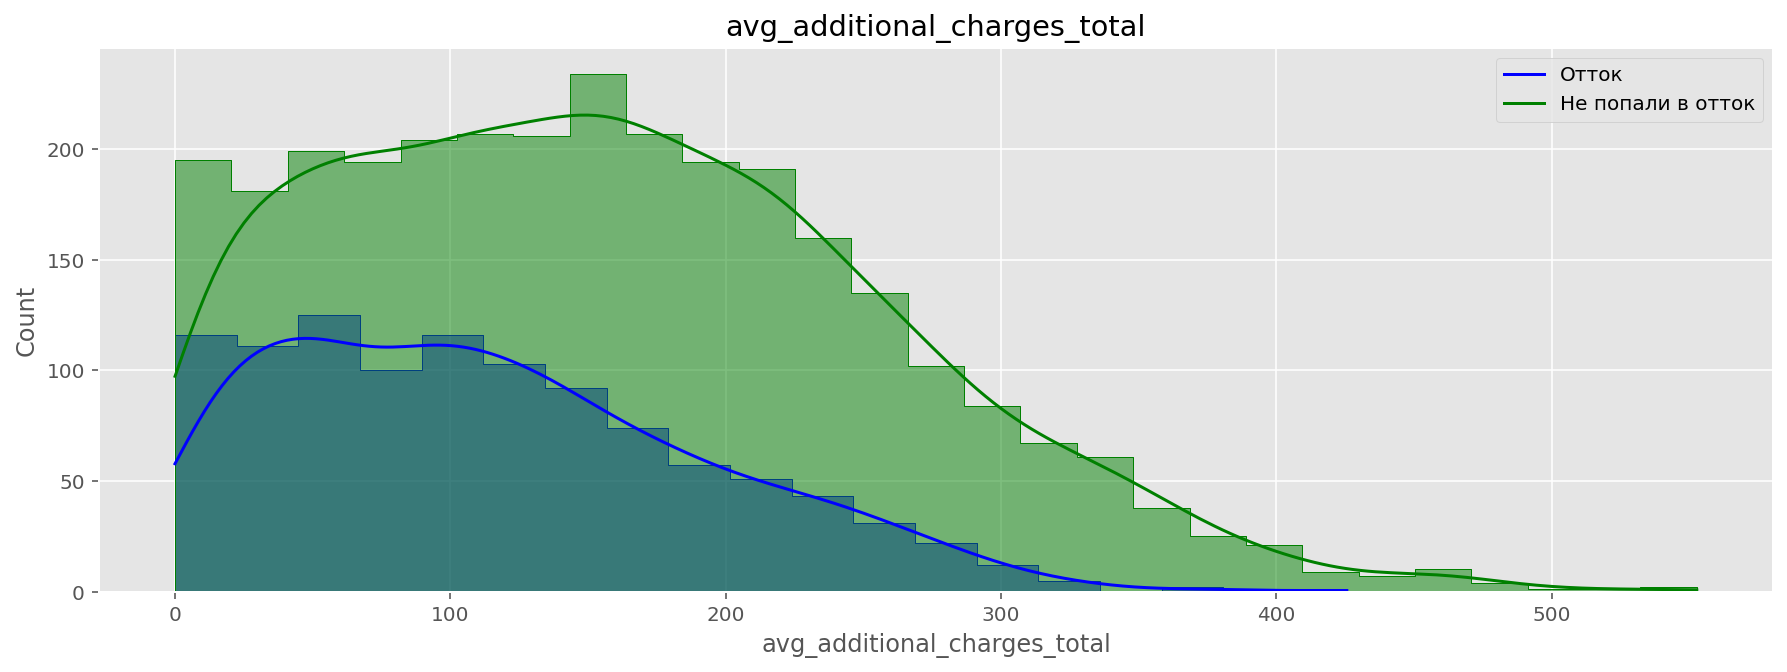

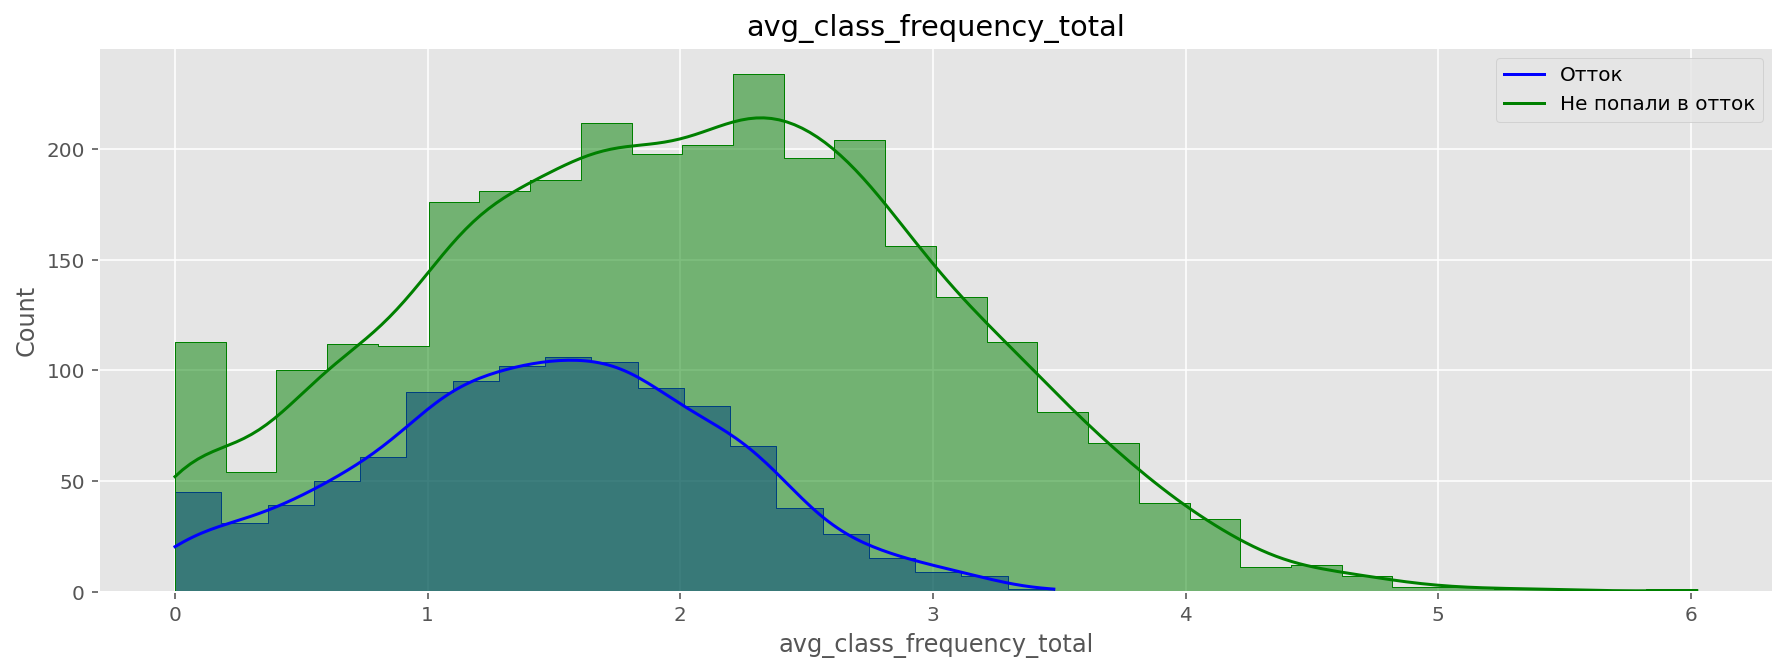

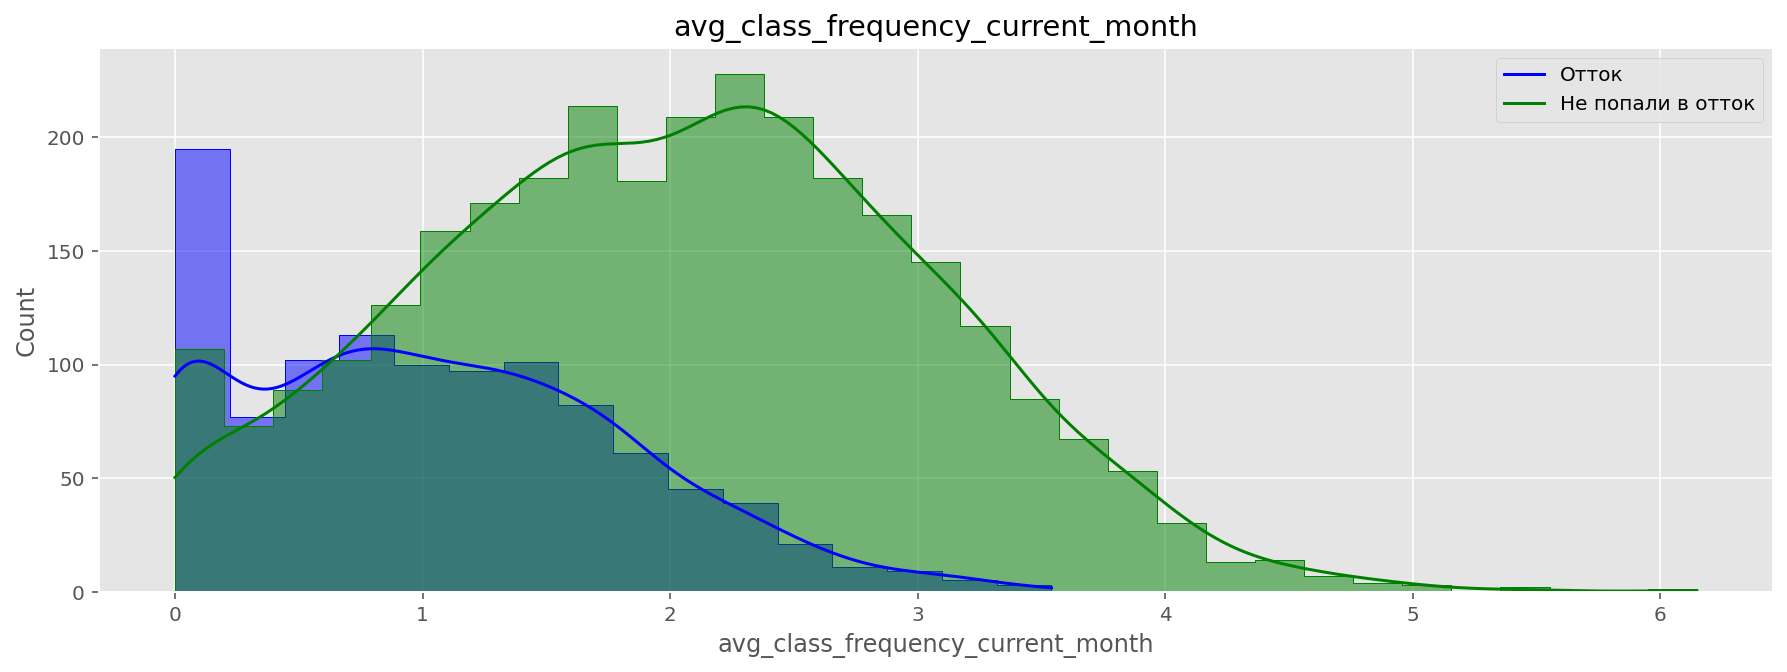

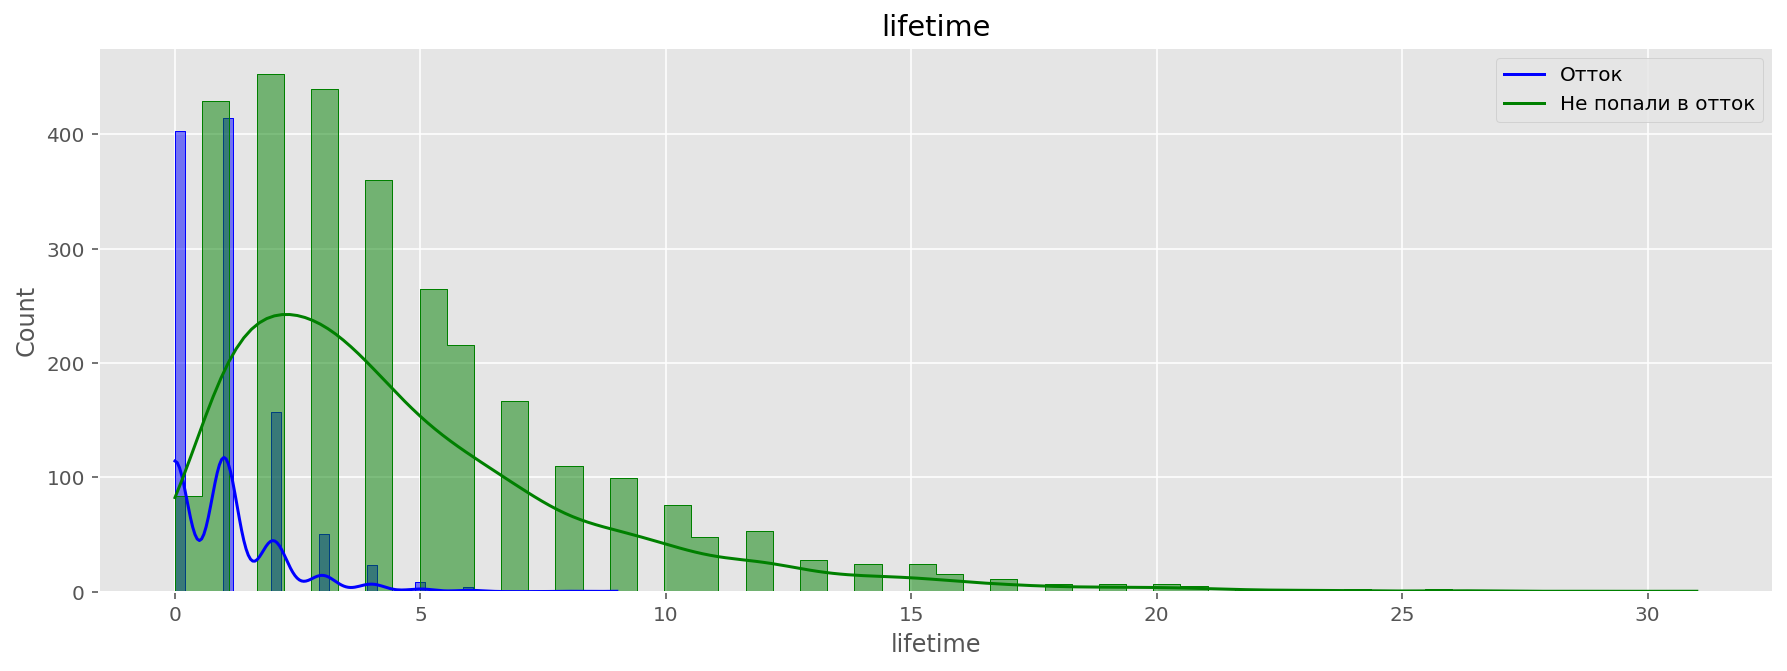

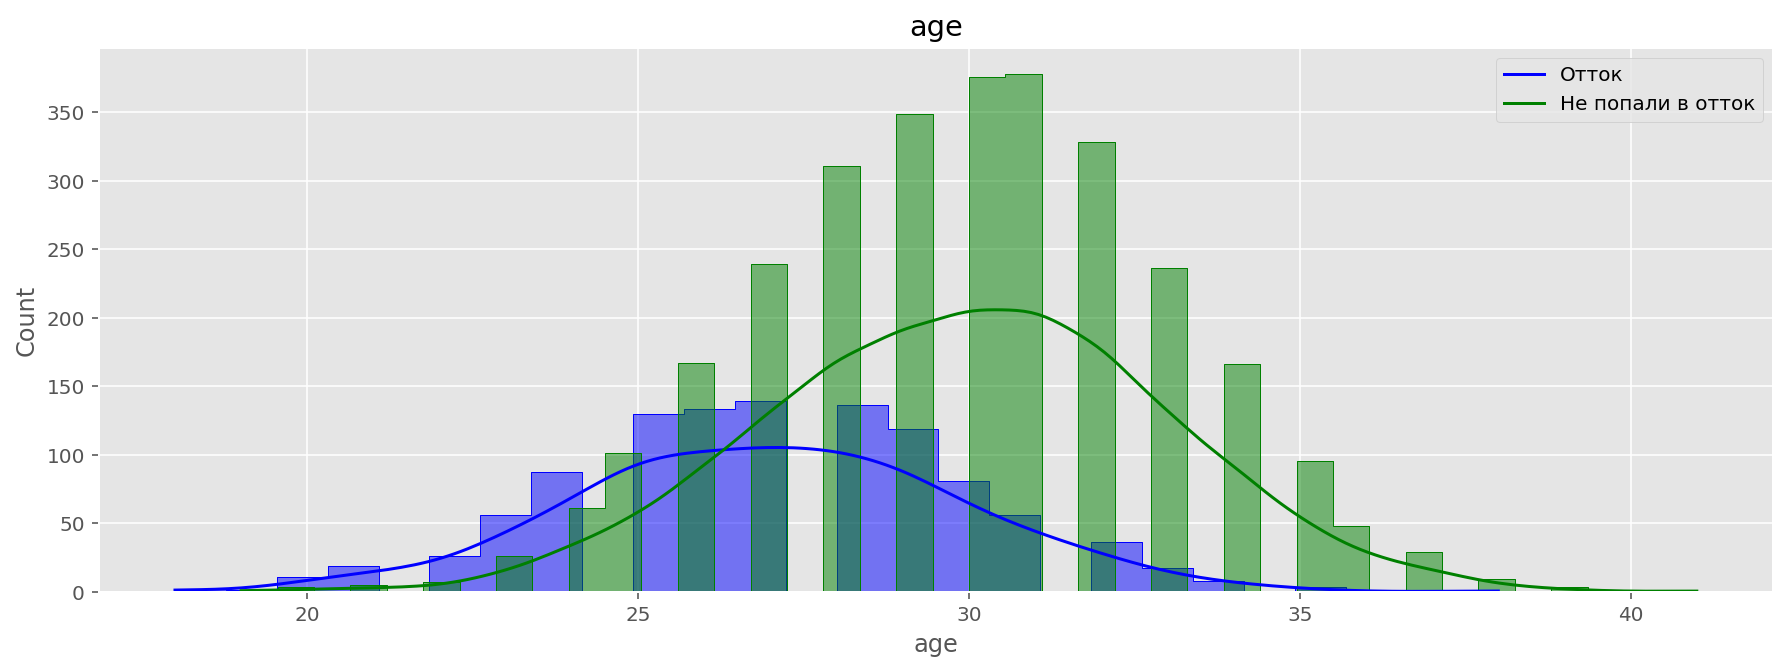

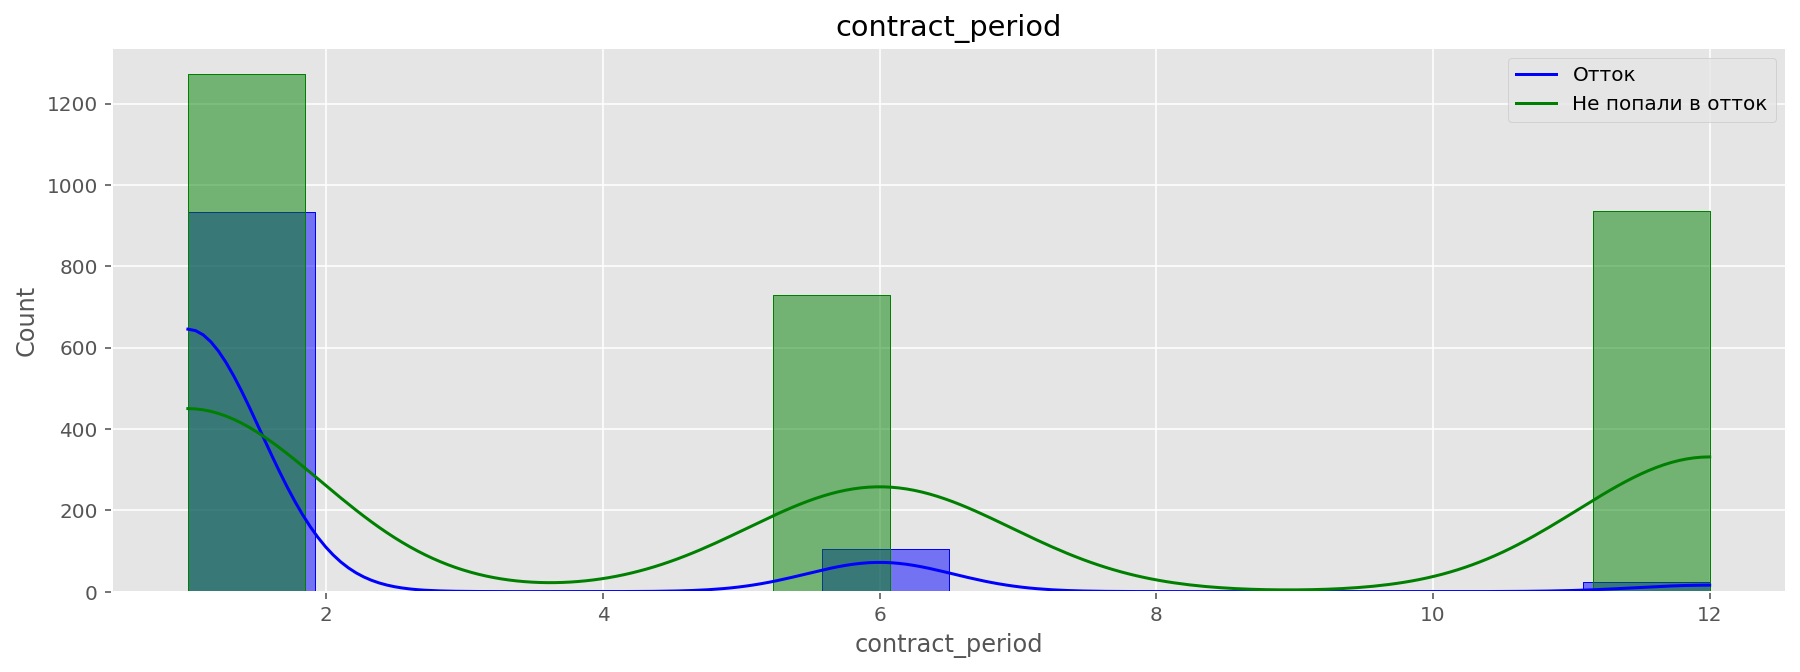

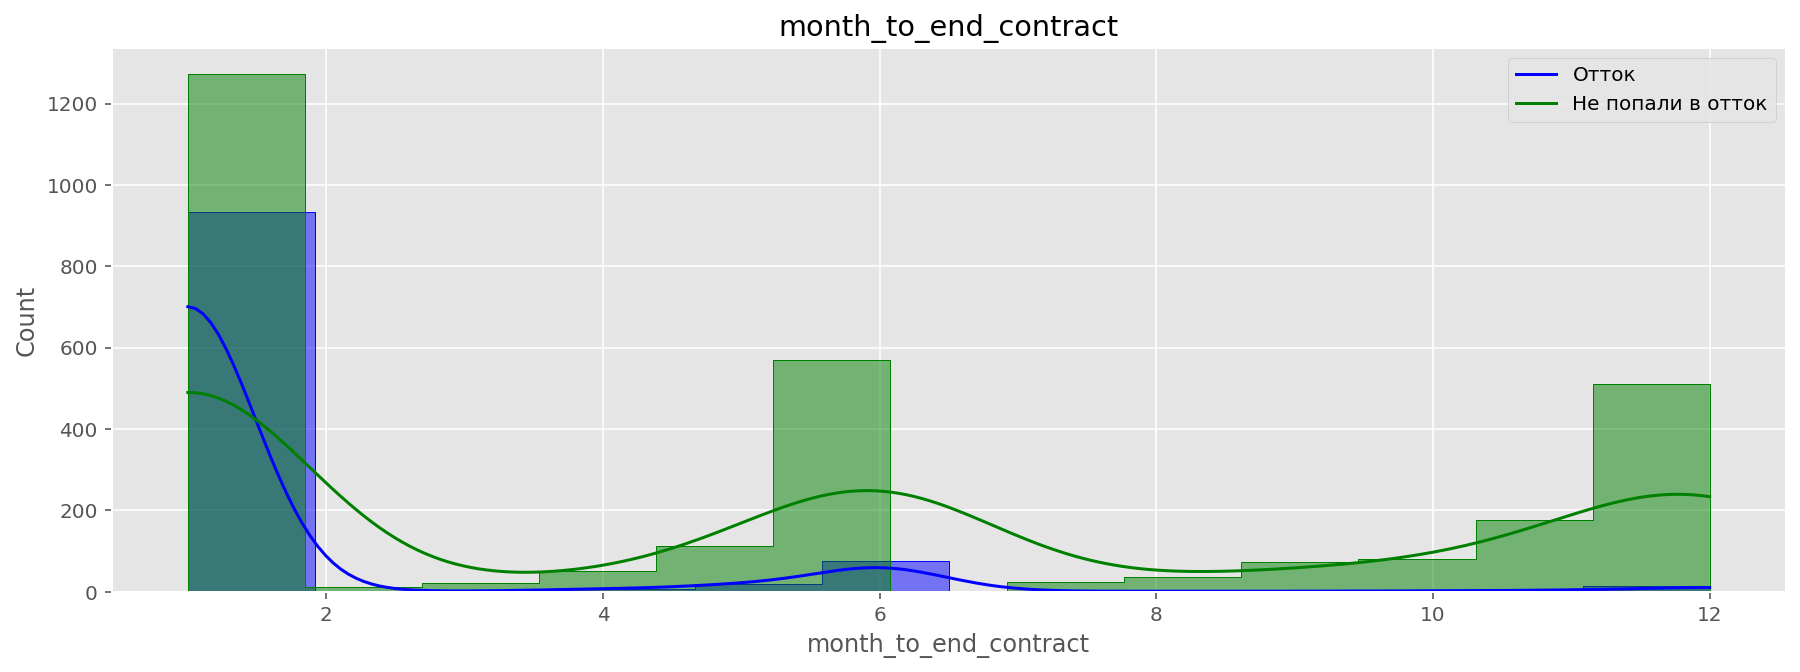

In [19]:
# разделим данные на две группы
left = df[df['churn']==1]   # отток
stayed = df[df['churn']==0] # не попали в отток

# сохраним необходимые нам столбцы количественных признаков в переменную histplot_columns_quantity
histplot_columns_quantity = ['avg_additional_charges_total', 
                             'avg_class_frequency_total', 
                             'avg_class_frequency_current_month', 
                             'lifetime', 'age','contract_period', 
                             'month_to_end_contract']


for column in histplot_columns_quantity:
    # зададим заголовок
    plt.title(column)
    # построим графики
    sns.histplot(left[column], kde=True, element='step', color=['blue'])
    sns.histplot(stayed[column], kde=True, element='step', color=['green'])
    # зададим значения легенды
    plt.legend(['Отток', 'Не попали в отток'])
    
    plt.show()

У клиентов, которые попали в отток суммарная выручка от других услуг, средняя частота посещений за предыдущий месяц и за все время с начала действия абонемента, длительность текущего действующего абонемента и даже возраст ниже чем у оставшихся клиентов.

Теперь построим гистограммы для качественных признаков.

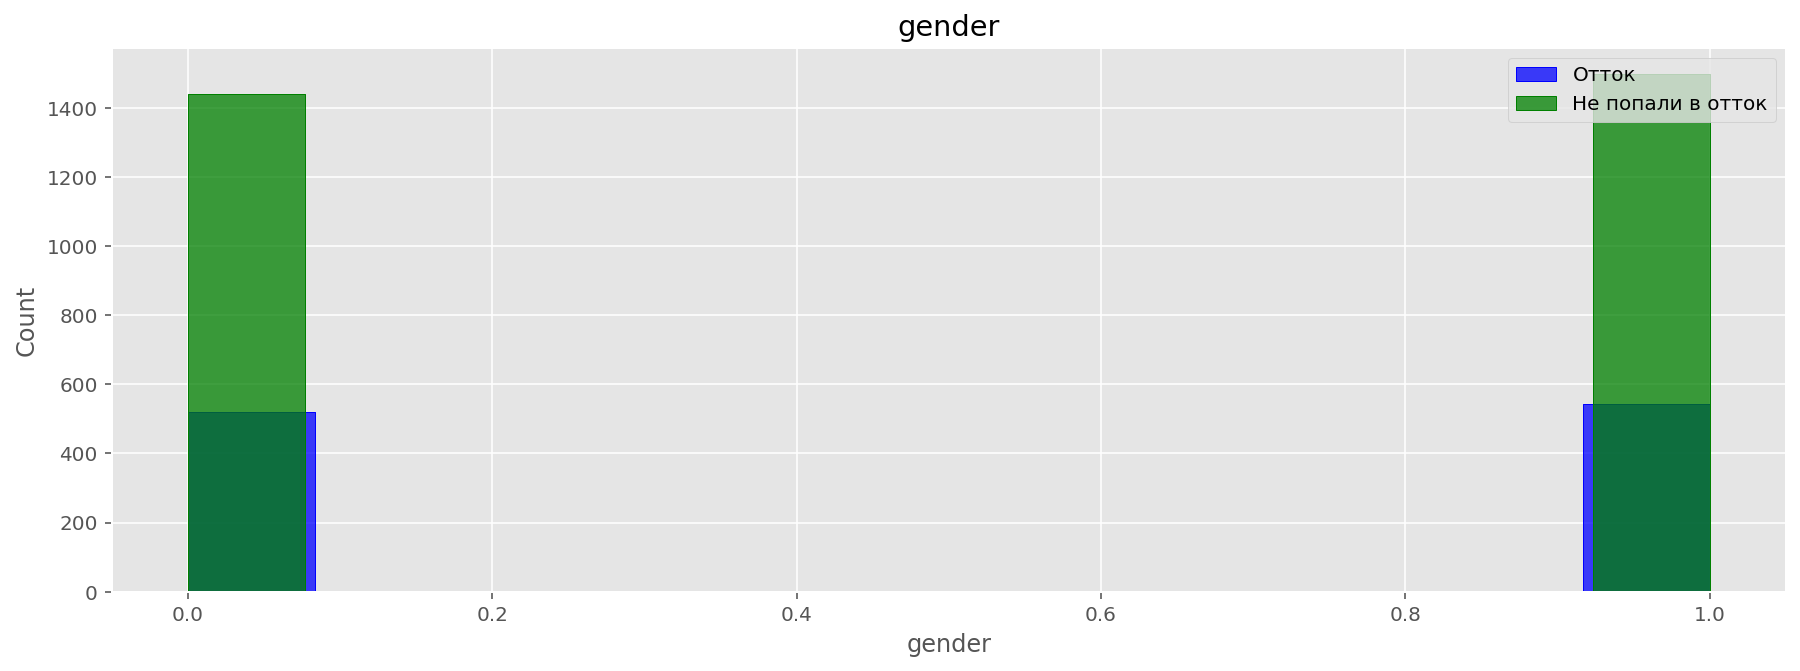

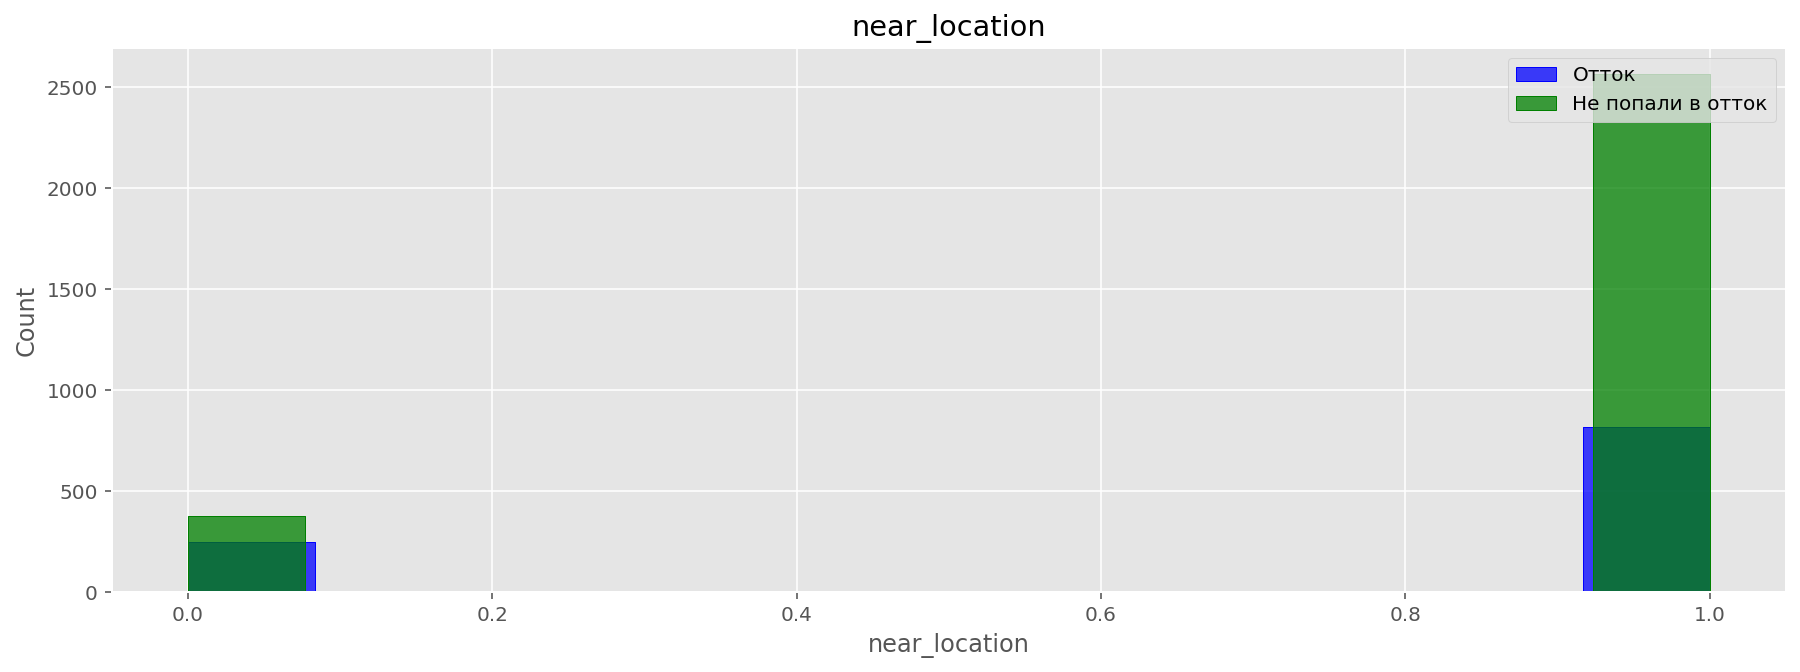

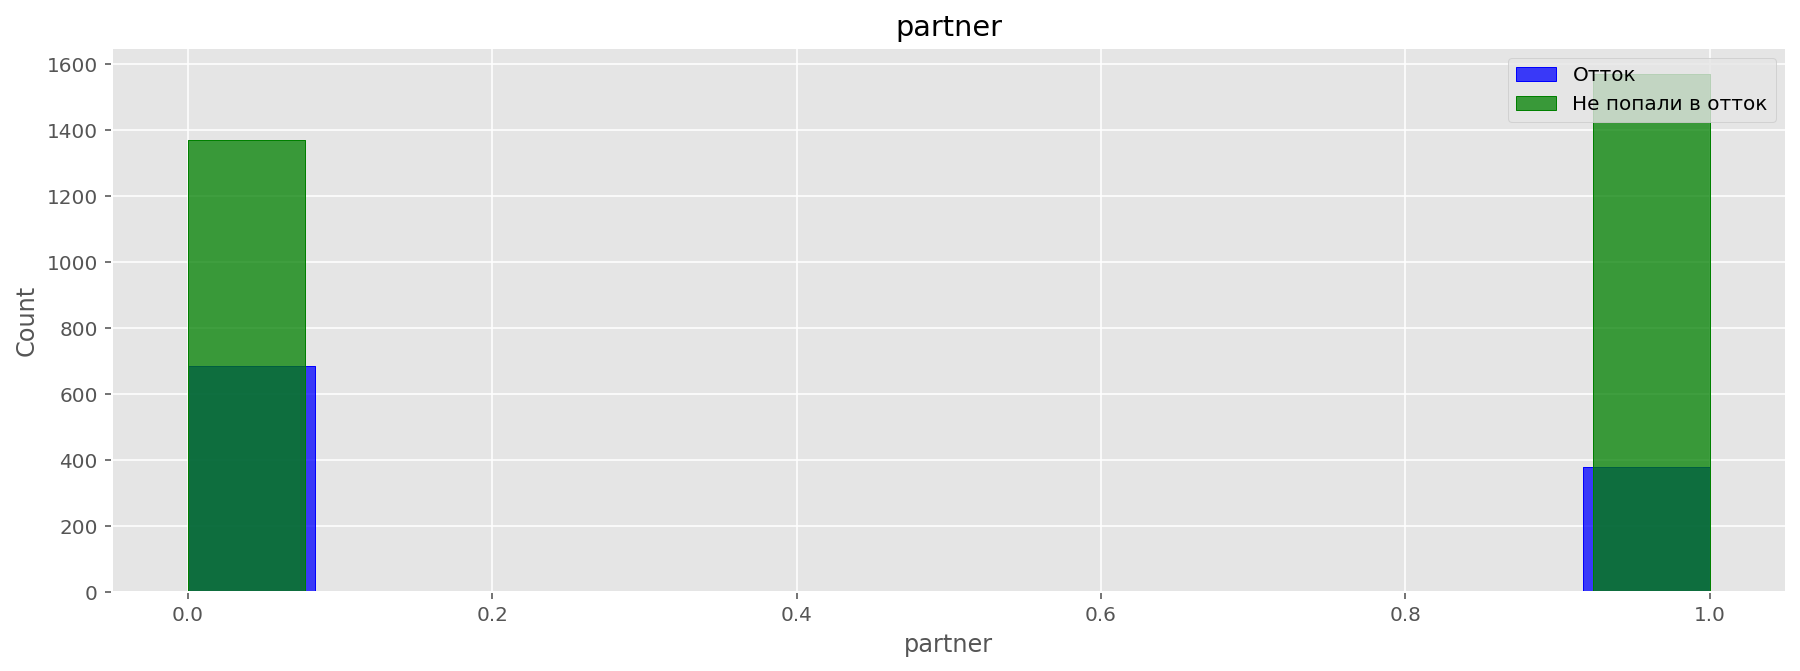

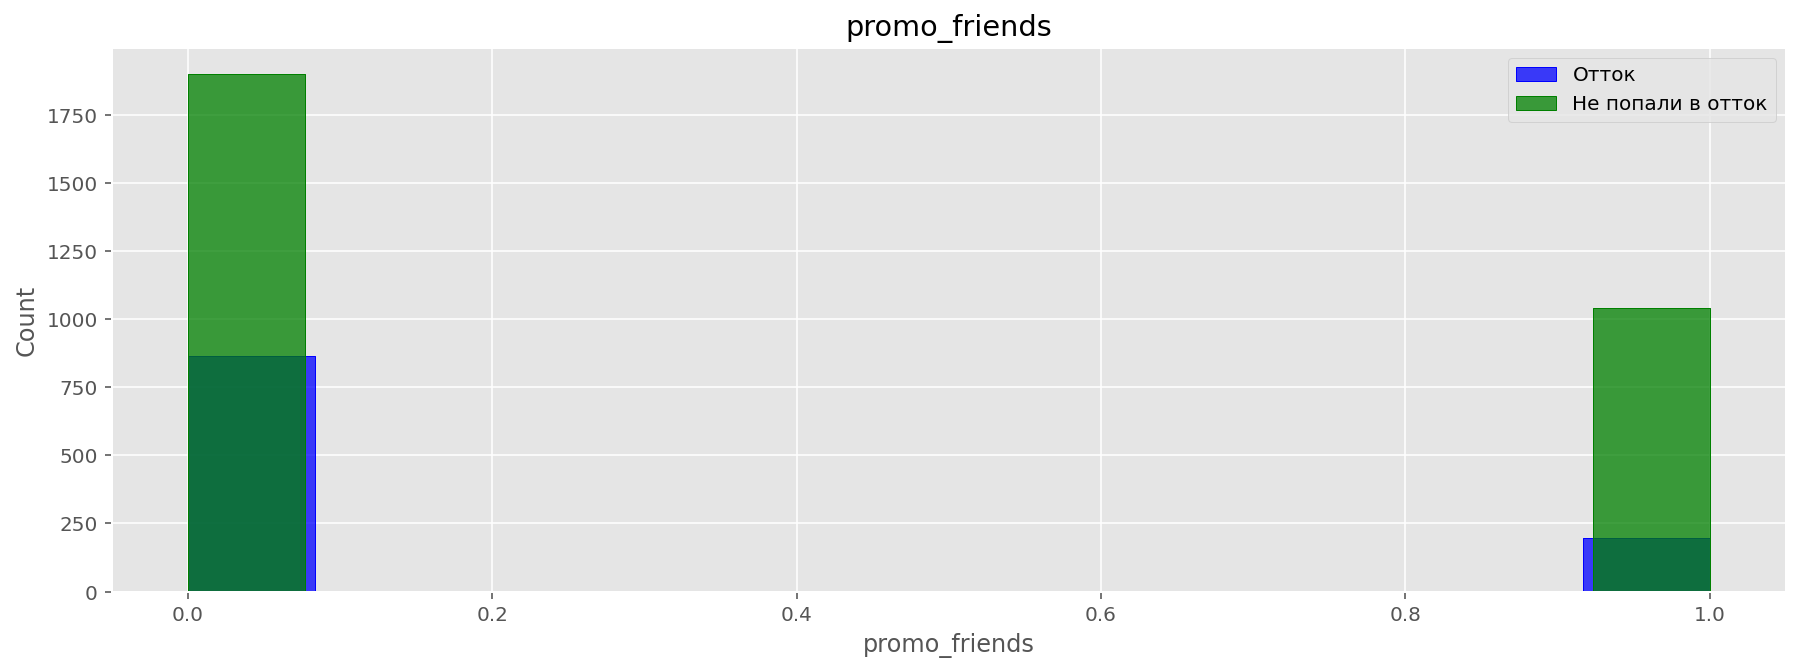

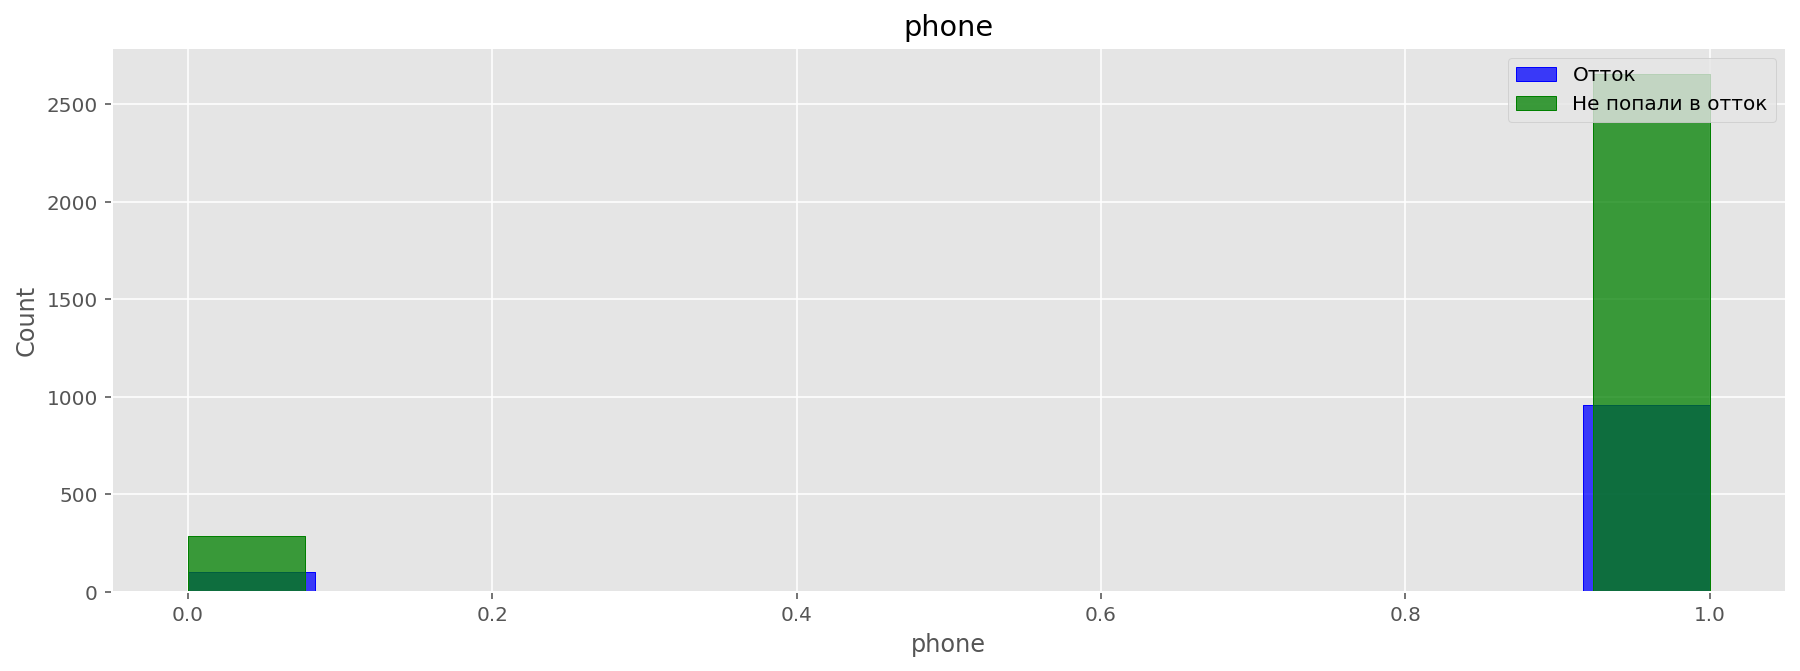

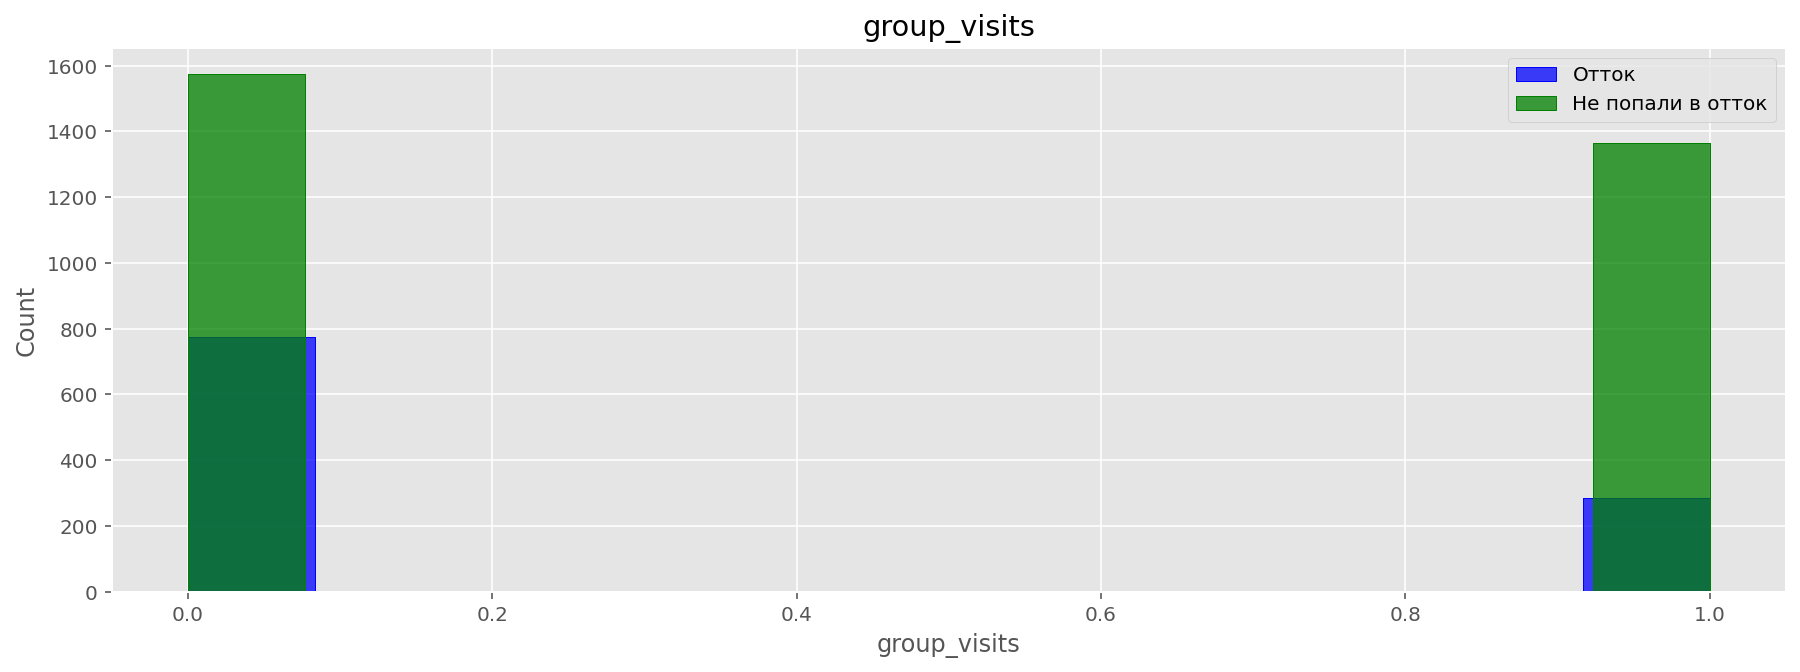

In [20]:
# сохраним необходимые нам столбцы в переменную histplot_columns_quality
histplot_columns_quality = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']


for column in histplot_columns_quality:
    # зададим заголовок
    plt.title(column)
    # построим графики
    sns.histplot(left[column], element='step', color=['blue'])
    sns.histplot(stayed[column], element='step', color=['green'])
    # зададим значения легенды
    plt.legend(['Отток', 'Не попали в отток'])
    
    plt.show()

Характерные признаки клиентов, которые не попали в отток:
* проживание или работа в районе, где находится фитнес-центр;
* работа в компании-партнёра клуба;
* факт первоначальной записи в рамках акции «приведи друга»;
* чаще оставляют свои контактные данные и посещают групповые занятия.

### Матрица корреляций

Построим матрицу корреляций и отобразим её.

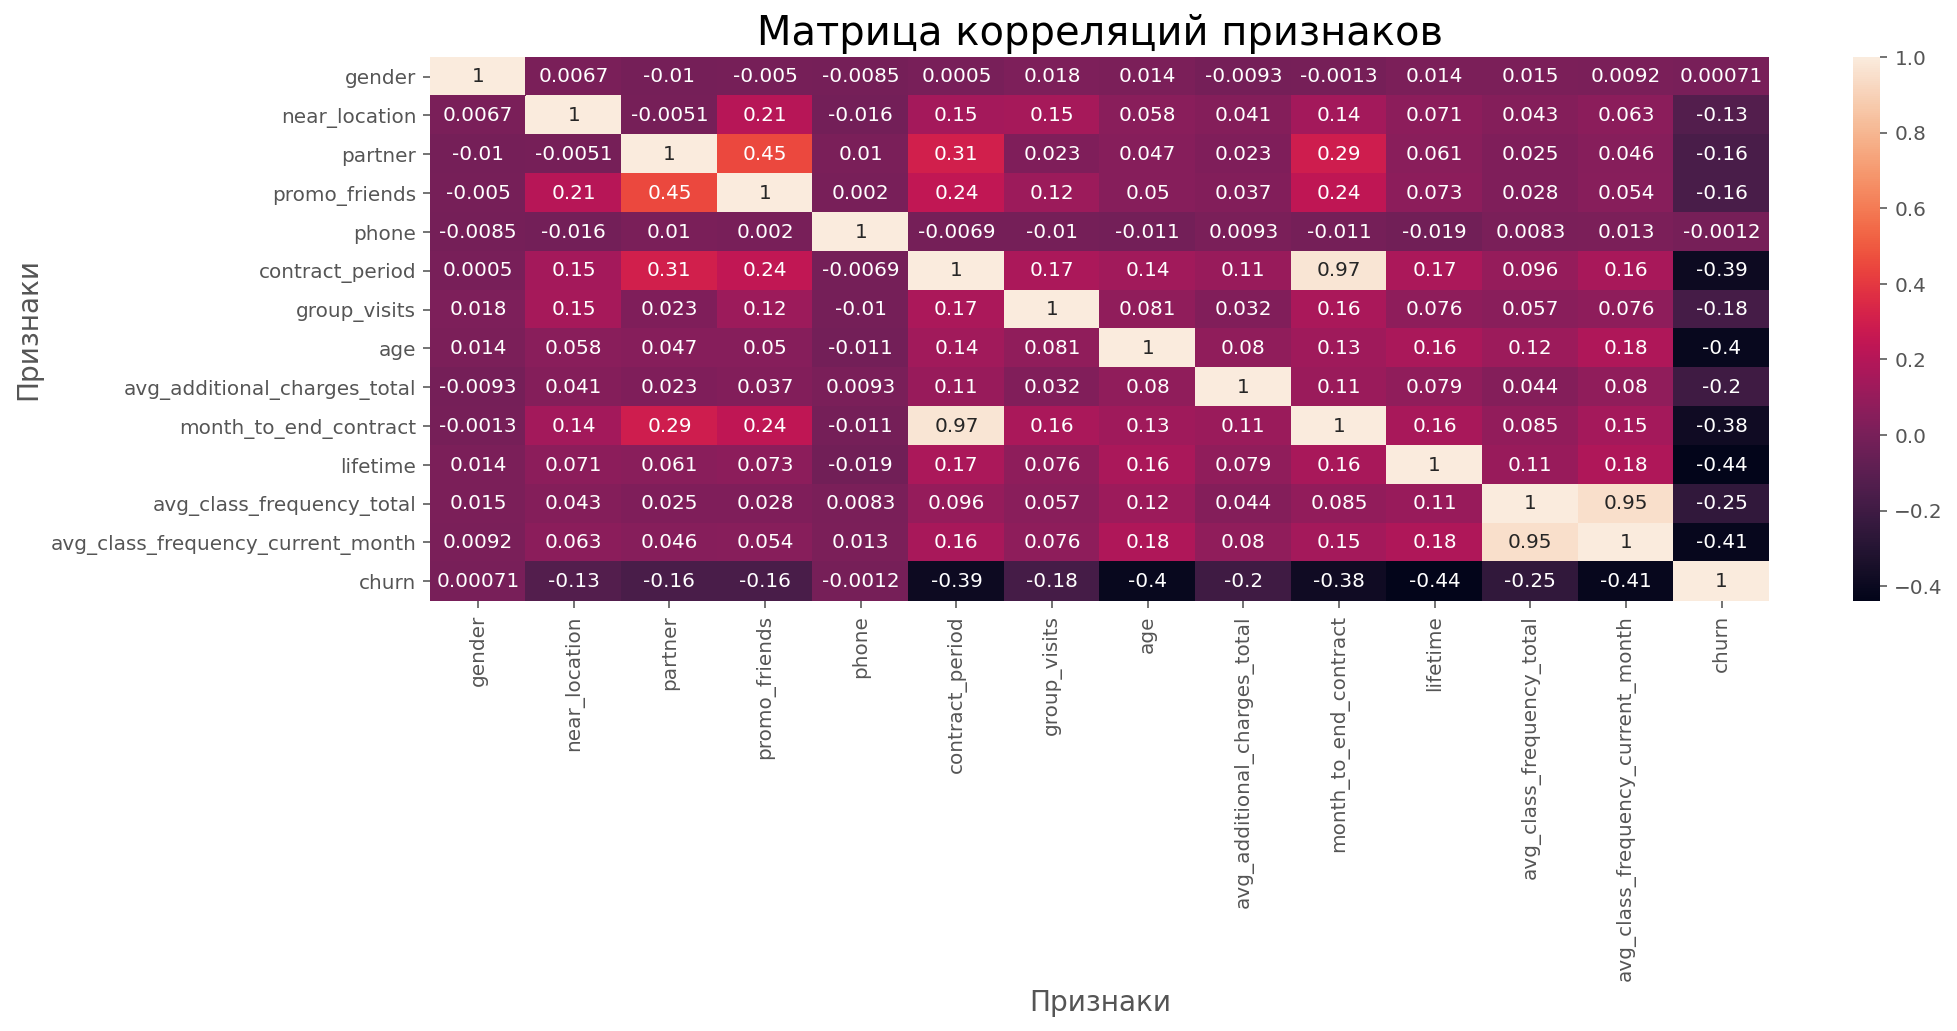

In [21]:
correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot = True, square=False)
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14)

plt.show()

Самая сильная корреляция у пар признаков:
* `Month_to_end_contract` и `Contract_period` - 0.97
* `Avg_class_frequency_current_month` и `Avg_class_frequency_total` - 0.95

Их коэффициенты слишком больше (больше 0,8). Возникает мультиколлинеарность. Это повлечет проблемы с линейной регрессией. В дальнейшем избавимся от одного из них.

Оставшиеся признаки слабо коррелируют друг с другом.

У большего количества признаков и Churn обратная корреляция:
* `gender/Churn` и `Phone/Churn` - корреляция на уровне 0
* `Near_Location/Churn, Partner/Churn, Promo_friends/Churn, Group_visits/Churn, Avg_additional_charges_total/Churn, Avg_class_frequency_total/Churn` - корреляция в диапазоне от -0.13 до -0.25
* `Contract_period/Churn, Age/Churn, Month_to_end_contract/Churn, Lifetime/Churn, Avg_class_frequency_current_month/Churn` - диапазон корреляции от -0.38 до -0.44.

Это говорит о том, что сила признака влияет на отток посетителей. Чем он сильнее тем слабее отток.

### Выводы

* Отсутствующих признаков нет;
* Для клиентов которые попали в отток характерны:
    - низкая суммарная выручка от других услуг; 
    - низкая средняя частота посещений за предыдущий месяц и за все время с начала действия абонемента; 
    - невысокая длительность текущего действующего абонемента;
    - возраст моложе 25 лет.
* Самая сильная корреляция у пар признаков Month_to_end_contract / Contract_period и Avg_class_frequency_current_month / Avg_class_frequency_total. Удалим один из них для избежания возникновения нерепрезентативных весов и переобученная модели под эти признаки.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Перед этим исключим мультиколлинеарность. Удалим по одному признаку в каждой паре.

In [22]:
df = df.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])

### Разбивка данных на обучающую и валидационную выборку функцией train_test_split()

In [23]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns = ['churn'])
y = df['churn']

In [24]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.2)

### Обучение модели на train-выборке двумя способами: логистической регрессией, случайным лесом

In [25]:
# зададим алгоритм для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [26]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
tree_model = RandomForestClassifier(n_estimators = 100, random_state=0)

# обучим модель
tree_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
tree_predictions = tree_model.predict(X_test)
tree_probabilities = tree_model.predict_proba(X_test)[:,1]

### Оценка метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнение модели. Какая модель показала себя лучше на основании метрик?

In [27]:
# выведем метрики 
print('Метрики для логистической регрессиии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Метрики для логистической регрессиии
Accuracy: 0.88
Precision: 0.76
Recall: 0.77


In [28]:
# выведем  метрики 
print('Метрики для модели случайный лес')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predictions)))

Метрики для модели случайный лес
Accuracy: 0.89
Precision: 0.78
Recall: 0.77


Показатели `доли правильных ответов (accuracy)` и `точности (precision)` немного лучше у модели случайного леса чем у логистической регрессии. Значения `полноты (recall)` одинаковые.

### Выводы

* Модель 'Cлучайный лес' лучше, чем 'Логистическая регрессия'.

## Кластеризация клиентов

Отложим в сторону столбец с оттоком и проведем кластеризацию объектов.

### Стандартизация данных

In [29]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler()

# обучаем нормализатор и преобразуем набор данных 
x_sc = scaler.fit_transform(df.drop(columns = ['churn'])) 

### Построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков и отрисовка дендрограммы. 

In [30]:
# в переменную linked сохраним таблицу «связок» между объектами
linked = linkage(x_sc, method = 'ward')

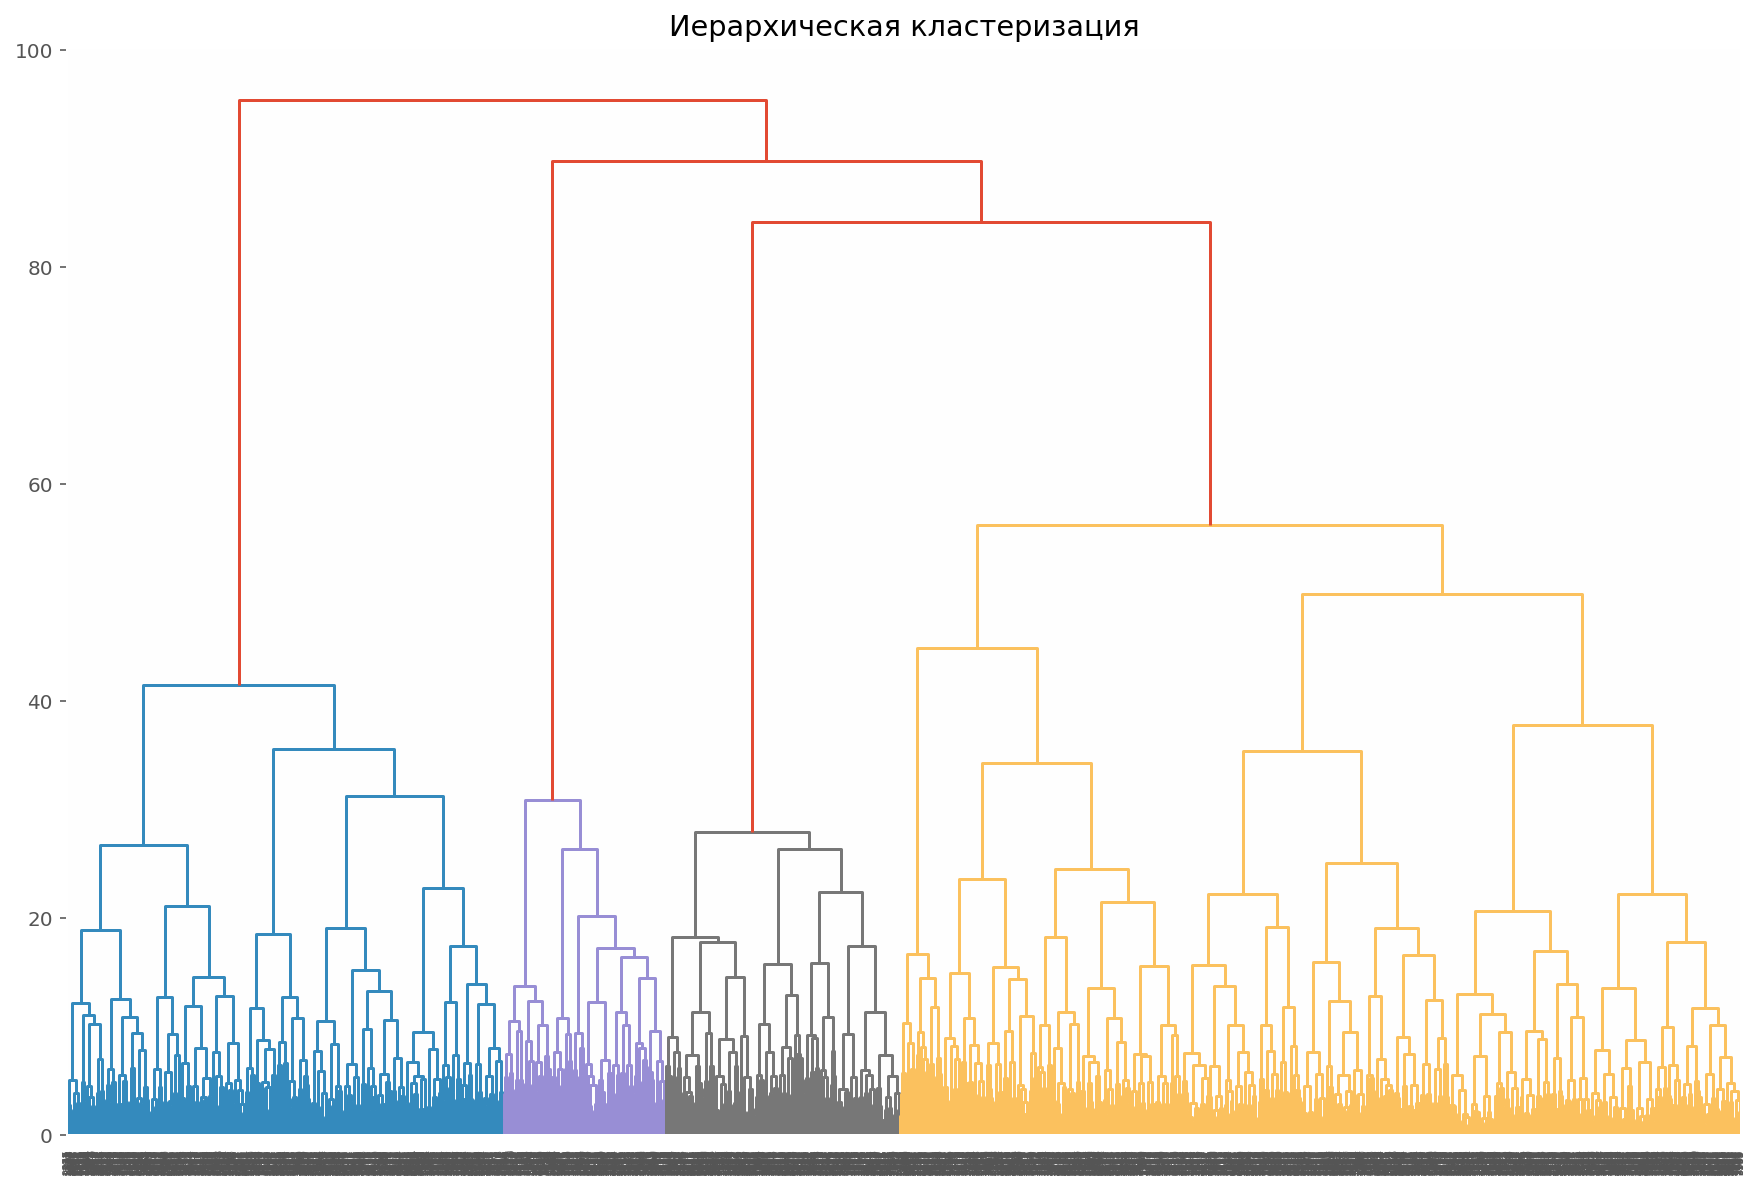

In [31]:
# отрисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')

plt.show() 

Один из кластеров достаточно объемный. Для удобства разделим дендограмму на 5 кластеров.

### Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов

In [32]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters = 5, random_state=0)

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(x_sc)

Используем метрику силуэта (silhouette score) чтобы посмотреть насколько объект своего кластера похож на свой кластер больше, чем на чужой. Выясним насколько качественно мы провели кластеризацию.

In [33]:
print('Silhouette_score:', silhouette_score(x_sc, labels))

Silhouette_score: 0.14081793708140083


Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация. Наш показатель - 0.14, что говорит о плохом качестве кластеризации.

### Средние значения признаков для кластеров

In [34]:
# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


Выясним количество клиентов в кластерах.

In [35]:
df.groupby(['cluster'])['gender'].count()

cluster
0     561
1    1050
2    1132
3     871
4     386
Name: gender, dtype: int64

**`Кластер 0`** 

Клиенты, которые живут или работают далеко от фитнес-центра. Около половины из них работает в компаниях-партнерах. Мотивационная программа «приведи друга» не вызывает у них интерес вовсе. Они оставляют свои контактные данные. Длительность текущего действующего абонемента - 3.03 месяцев. Они не очень любят групповые тренировки. Их показатель суммарной выручки от других услуг составляет - 137.54. Это самое низкое значение. Средняя частота посещений в неделю за все время с начала действия абонемента составляет - 1.77 раз. У них самых высоких показателей оттока среди всех кластеров.


**`Кластер 1`**
Клиенты, которые живут или работают в районе, где находится фитнес-центр. Большая их часть это сотрудники компании-партнёра клуба. Практически весь кластер воспользовался программой «приведи друга». Они с готовностью оставляют свои контактные данные. Их средняя длительность текущего действующего абонемента более 7.6 месяцев. У них самое высокое среднее значение возраста среди всех категорий (около 30 лет). Самые большие любители групповых занятий среди клиентов всех категорий. У них самый высокий показатель затрат на другие услуг фитнес-центра - 155.86. Средняя частота посещений в неделю за все время с начала действия абонемента - 1.97 раз. У них самый низкий показатель оттока.


**`Кластер 2`** 

Клиенты живут или работают в районе, где находится фитнес-центр (100% клиентов). Среди них меньше всего людей сотрудников компании-партнёра клуба. Они практически не пользуются акцией «приведи друга». Длительность текущего действующего абонемента - 2.81 мес. Скорее всего они предпочитают самостоятельные занятия групповым тренировкам. У них самый низкий показатель по этому признаку среди всех категорий. 143.38 - их показатель суммарной выручки от других услуг. Средняя частота посещений в неделю за все время с начала действия абонемента - 1.80 раз. Клиенты кластера занимают второе место по показателю оттока.


**`Кластер 3`**

Это клиенты, которые живут или работают в районе, где находится фитнес-центр (100% состав кластера). Они редко пользуются промо «приведи друга» и практически не работают в компаниях-партнерах. Они оставляют свои контактные данные. Длительность текущего действующего абонемента - 4.52 месяца. Это единственная группа, которая посещает групповые тренировки полным составом. На доп. услуги фитнес-центра клиенты тратят - 148.08. Время с момента первого обращения в фитнес-центр - 3.76 месяцев. Средняя частота посещений в неделю за все время с начала действия абонемента самая низкая среди всех кластеров - 1.94. 


**`Кластер 4`**

Клиенты, которые живут или работают в районе, где находится фитнес-центр. Половина клиентов работает в компаниях-партнерах клуба. Редко пользуются программой «приведи друга». Не оставляют свои контактные данные. Примерно половина из них посещает групповые занятия. Время с момента первого обращения в фитнес-центр - 3.94 месяца. Средняя частота посещений в неделю за все время с начала действия абонемента самая высокая среди всех кластеров - 1.85. Они на втором месте по показателю оттока.

### Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

Построим графики оценки плотности ядра признаков. В начале сделаем это для количественных, а потом для качественных признаков.

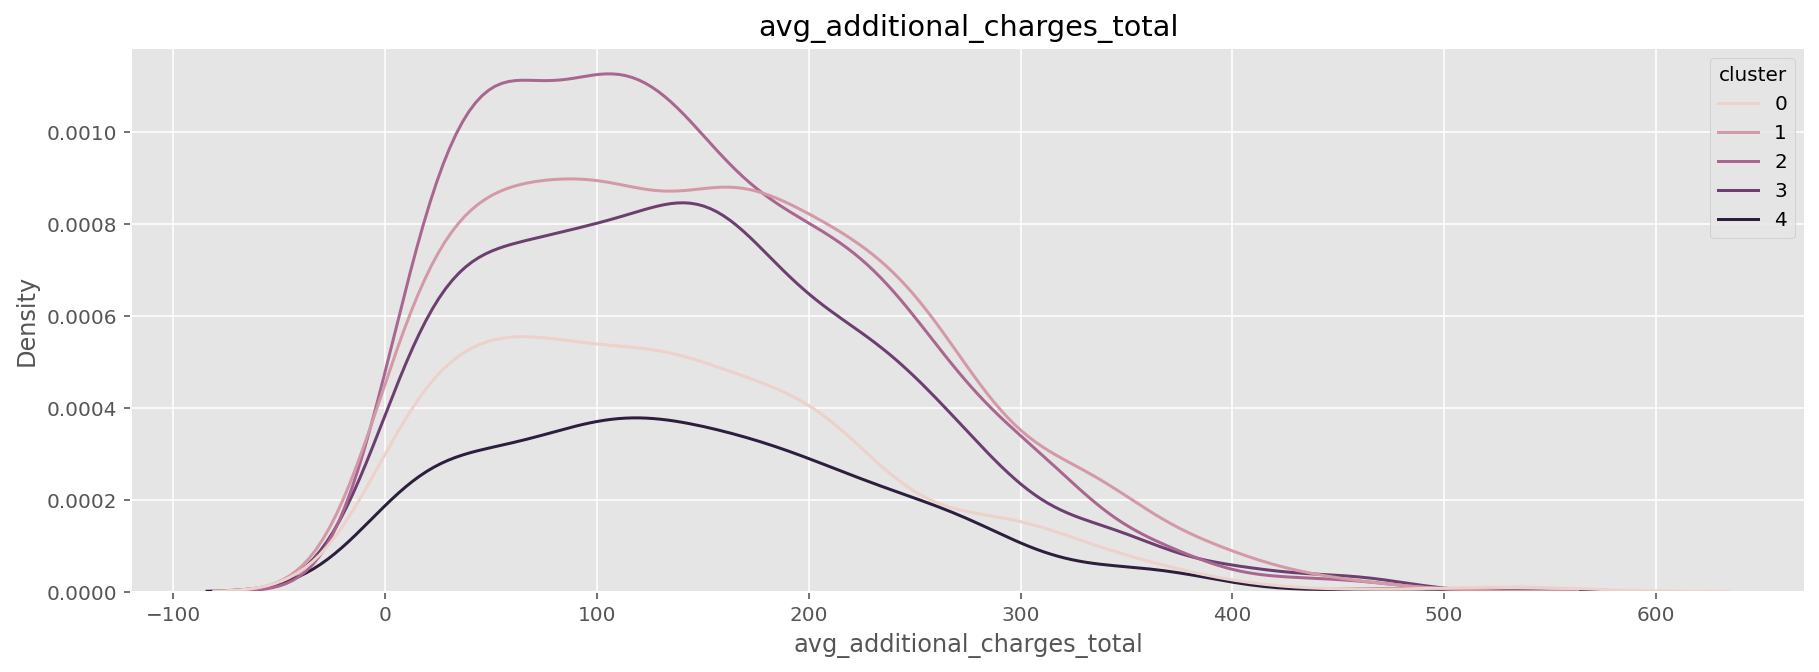

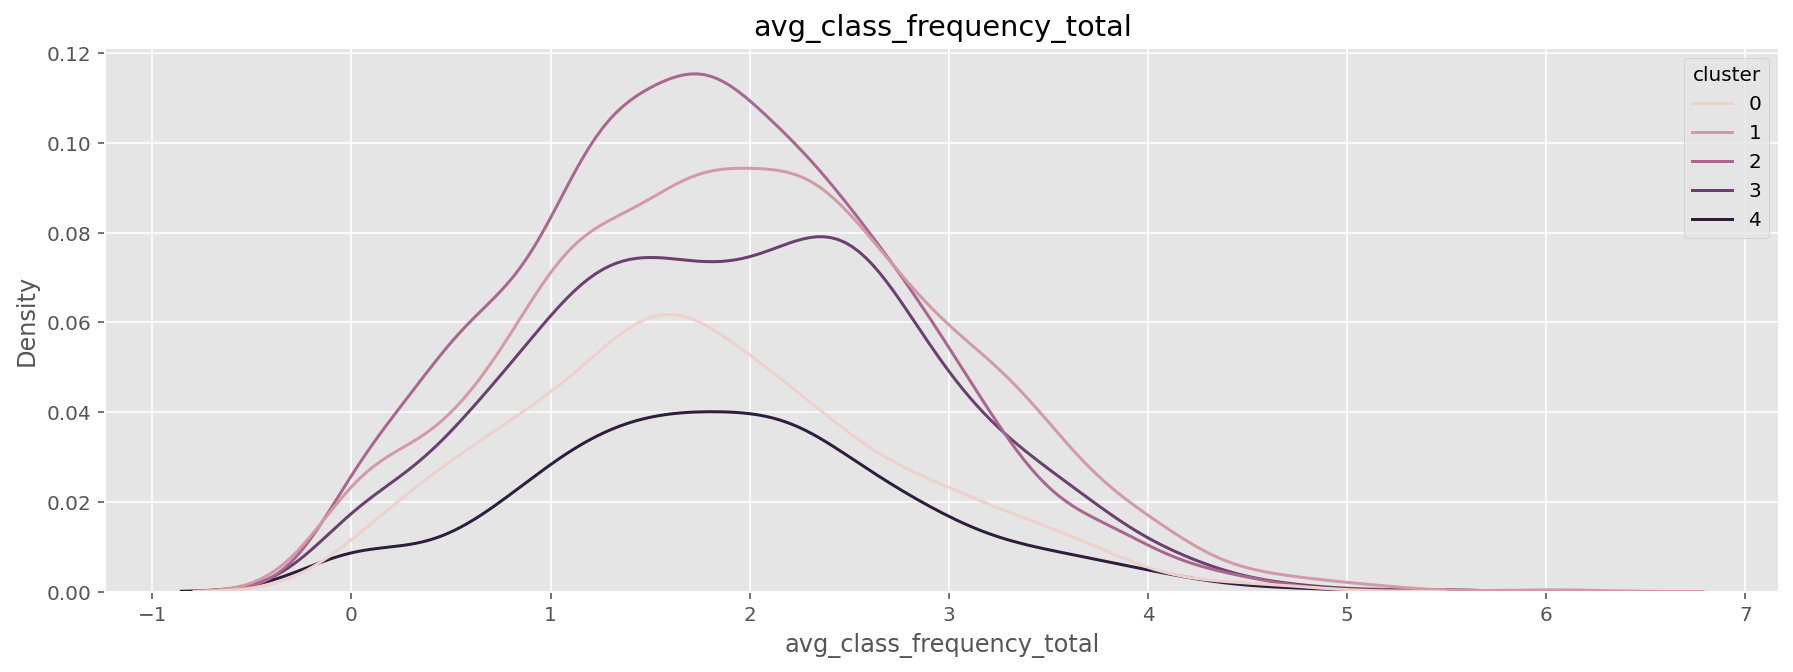

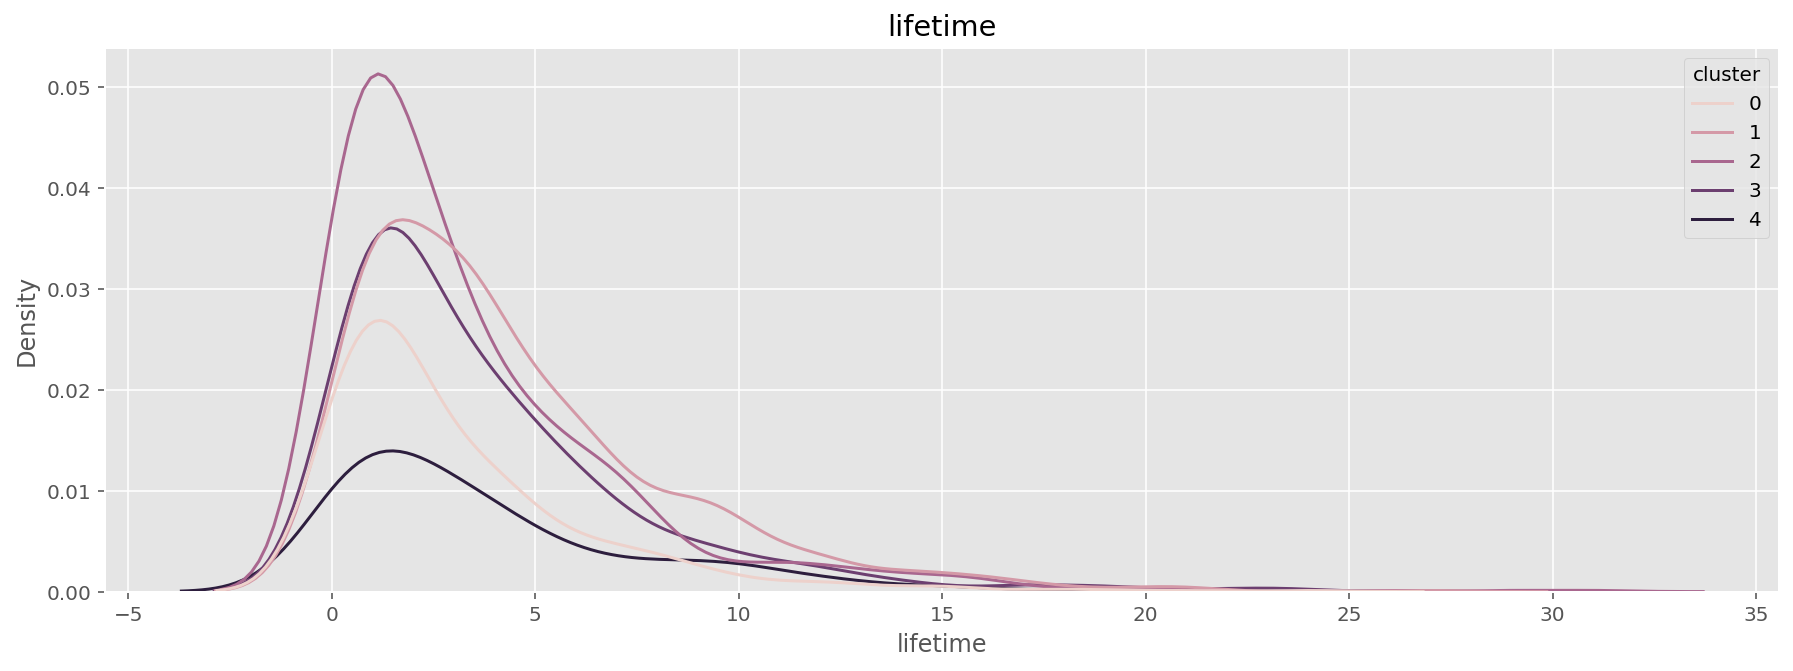

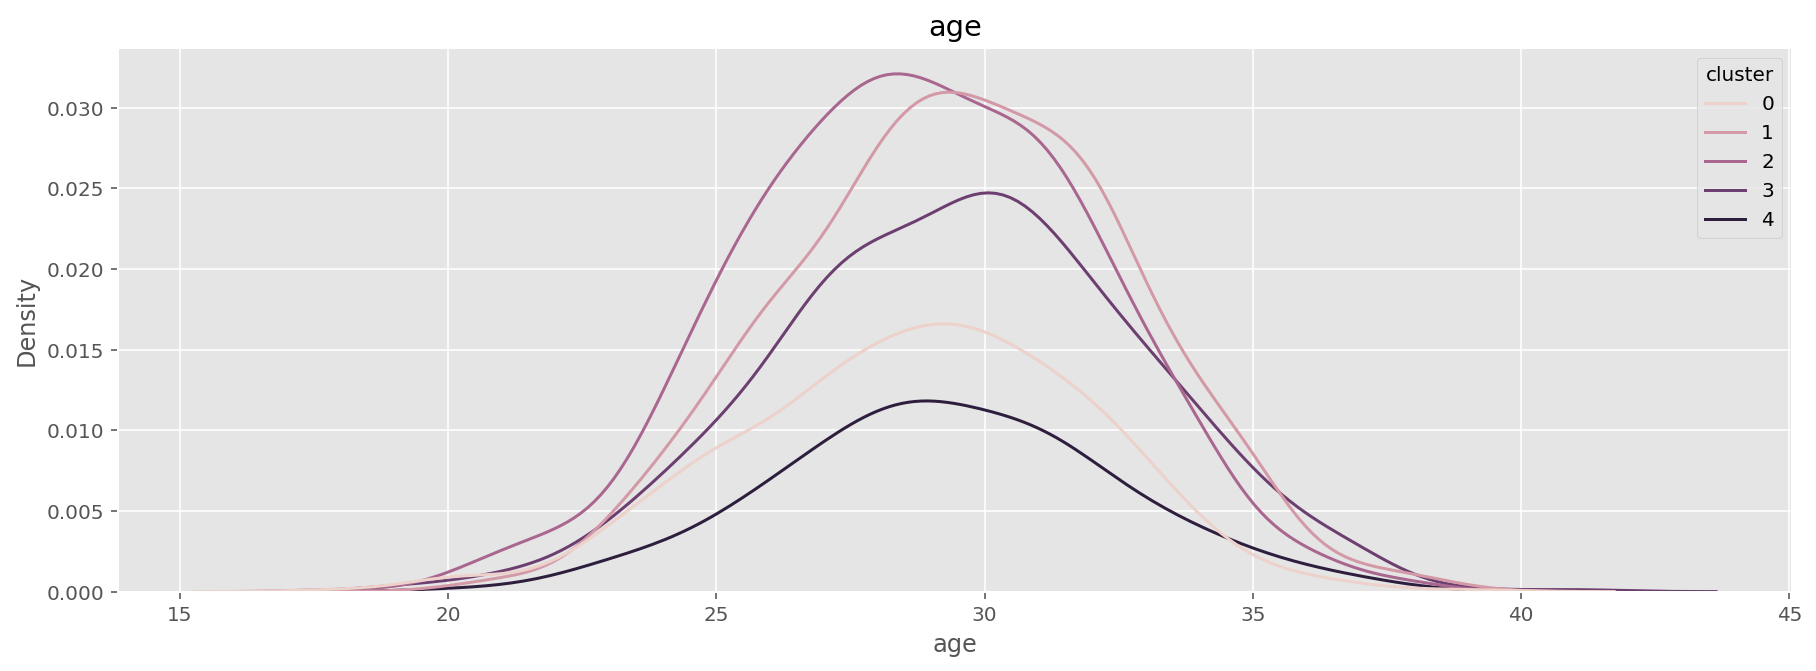

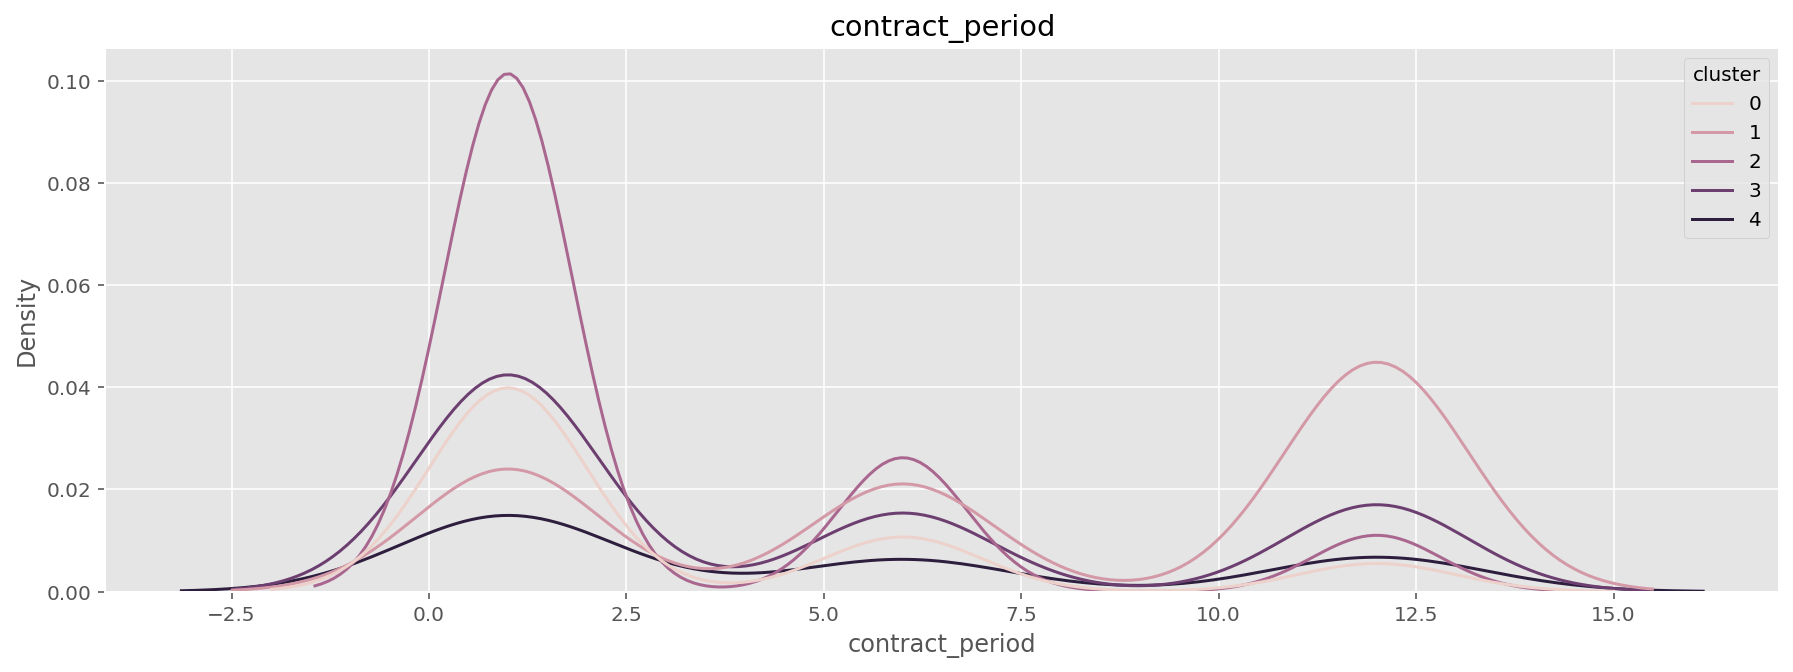

In [36]:
# графики оценки плотности ядра для  количественных признаков
# обновим переменную histplot_columns_quantity для построения графиков. Переименуем ее в histplot_columns_quantity_new
histplot_columns_quantity_new = ['avg_additional_charges_total', 
                                 'avg_class_frequency_total',
                                 'lifetime', 
                                 'age', 
                                 'contract_period']


for column in histplot_columns_quantity_new:
    sns.kdeplot(x=column, hue='cluster', data=df)
    plt.title(column)

    plt.show()

* `avg_additional_charges_total`- больше всего суммарной выручки от других услуг фитнес-центра приносят клиенты из кластера 1;
* `avg_class_frequency_total`- чаще всего клуб посещают клиенты из кластера 1 и 3, а реже из кластера 0;
* `lifetime`- больше всего времени с момента первого обращения в фитнес-центр прошло у клиентов кластеров 1 и 4;
* `age`- самая «взрослая» категория клиентов находится в кластере 1;
* `contract_period`- самая высокая длительность текущего действующего абонемента у клиентов кластера 1, а самая низкая у клиентов кластера 2.

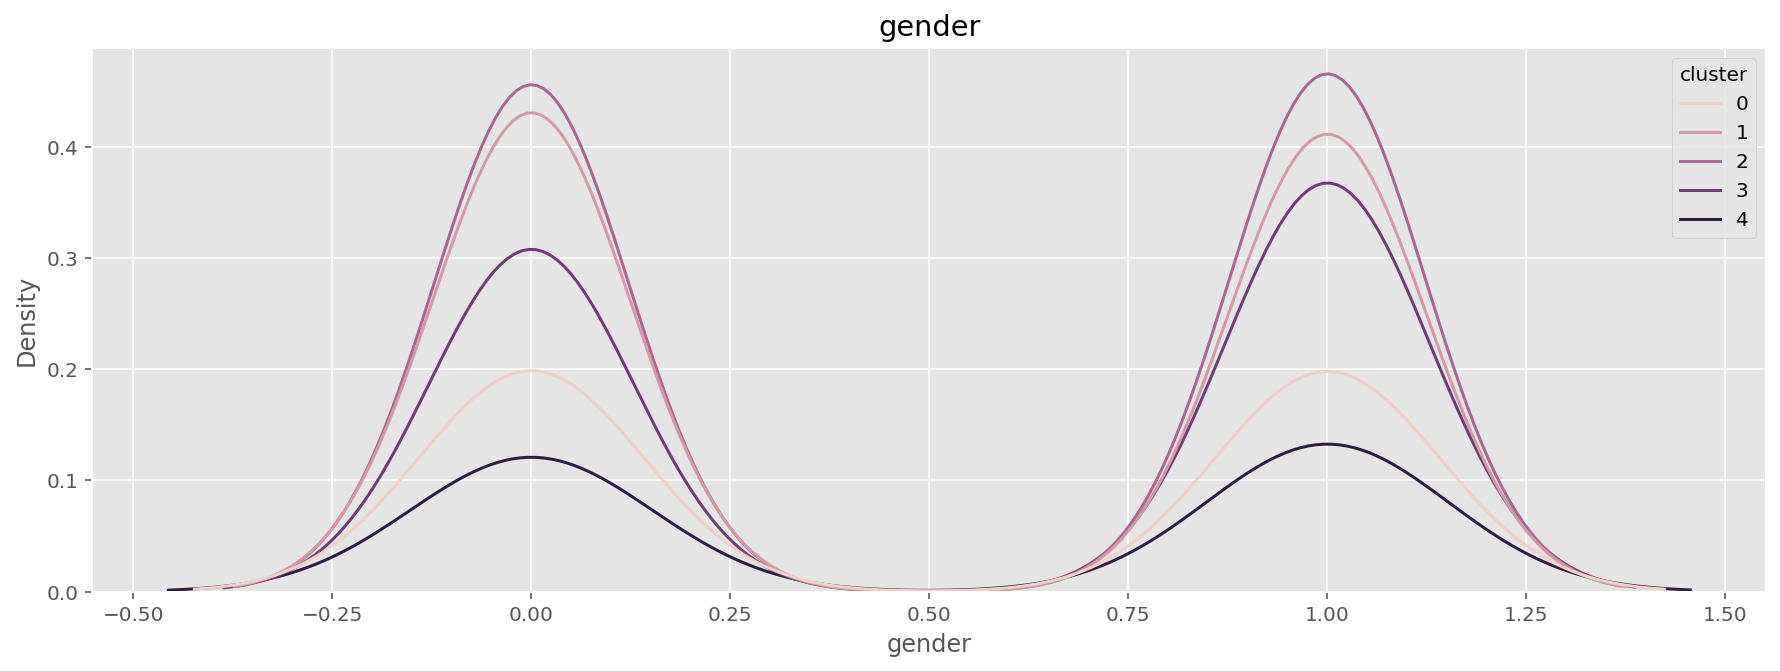

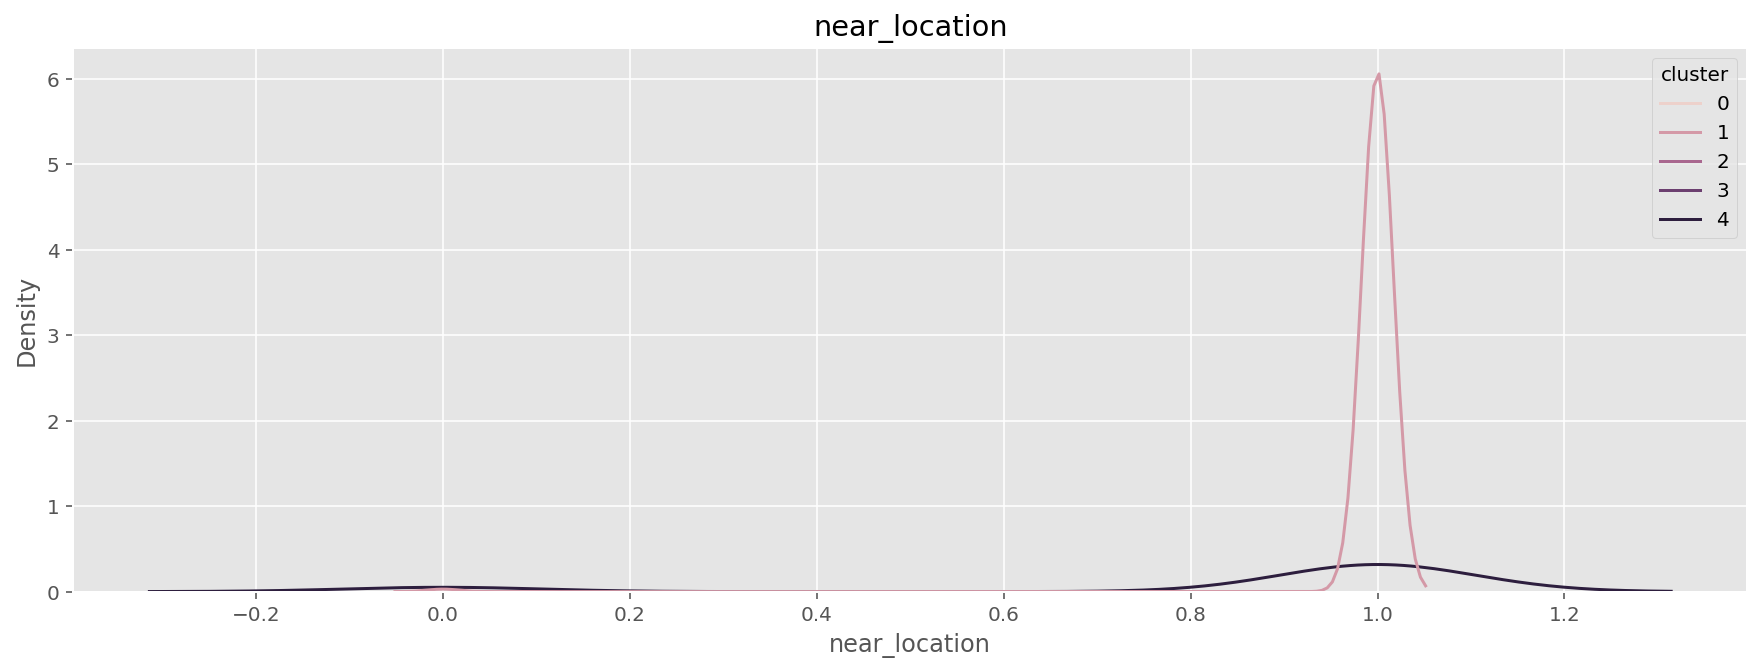

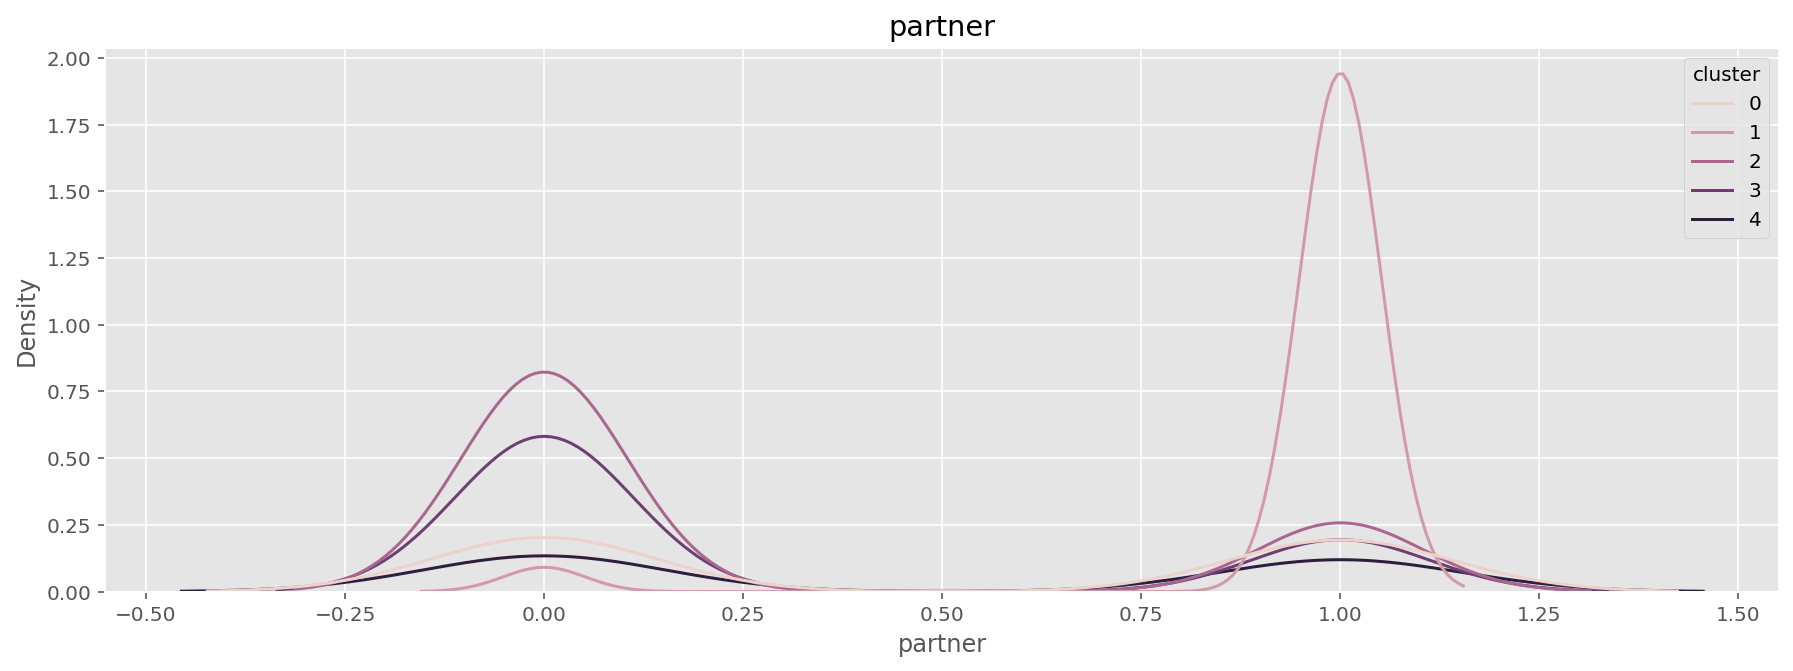

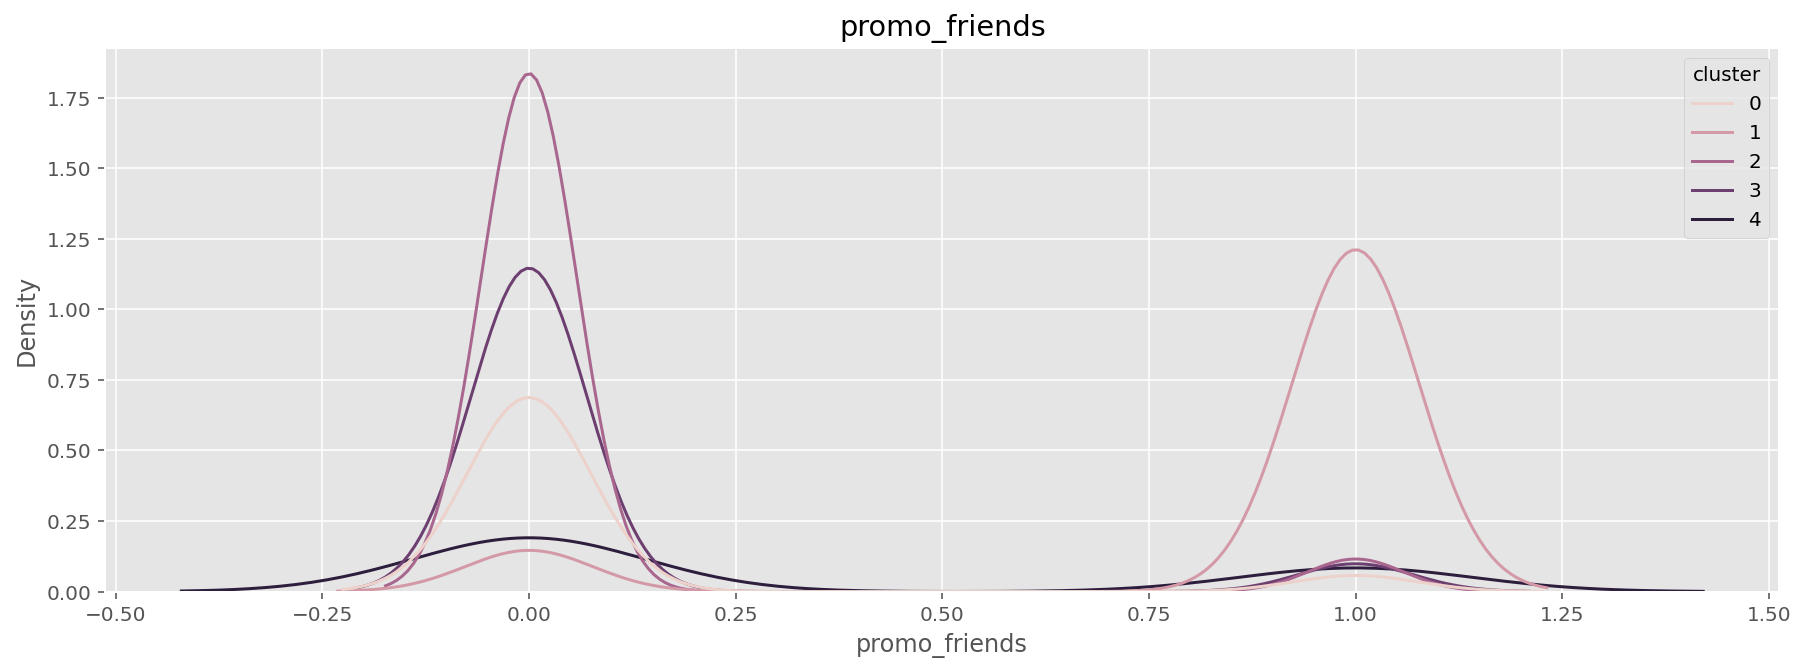

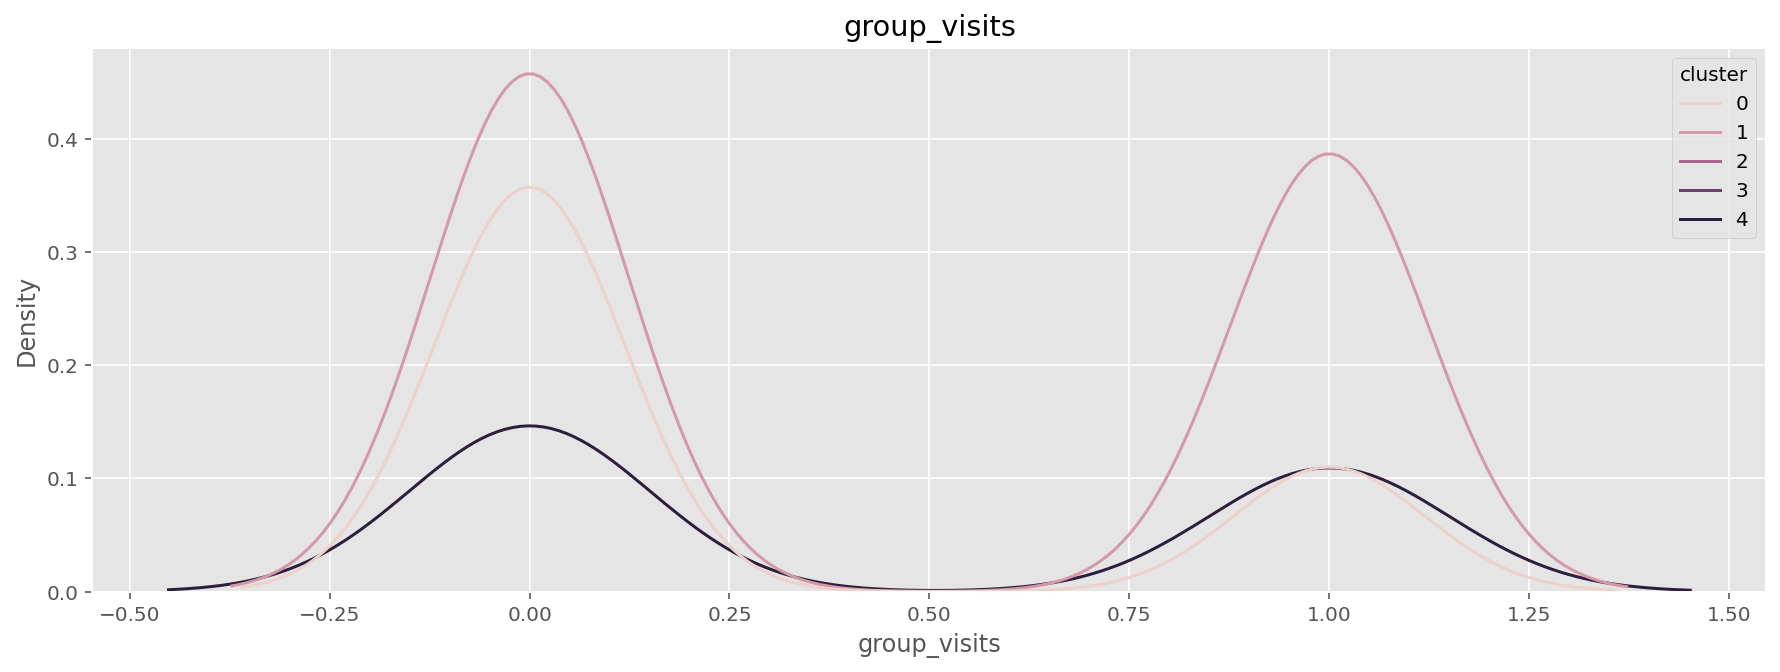

In [37]:
# графики оценки плотности ядра для качественных признаков
# обновим переменную histplot_columns_quality для построения графиков. Переименуем ее в histplot_columns_quality_new
histplot_columns_quality_new = ['gender', 'near_location', 'partner', 'promo_friends', 'group_visits']

for column in histplot_columns_quality_new:
    #plt.figure(figsize=(12, 4))
    sns.kdeplot(x=column, hue='cluster', data=df)
    plt.title(column)

    plt.show()

* `gender` - распределение пола по всем кластерам практически одинаковое;
* `near_location` - клиенты из кластера 0 живут и работают далеко от фитнес-центра; 
* `partner` - в основном сотрудниками компаний-партнёров клуба являются клиенты из кластера 1;
* `promo_friends` - активней всего акцией «приведи друга» пользуются клиенты из кластера 1;
* `group_visits` - самыми большими поклонниками групповых занятий являются клиенты кластера 3.

### Доля оттока для каждого полученного кластера

Посчитаем долю оттока для каждого кластера.

In [38]:
propensity_to_churn = df.groupby('cluster')['churn'].agg('sum') / df.groupby('cluster')['churn'].size()

In [39]:
propensity_to_churn

cluster
0    0.399287
1    0.120952
2    0.381625
3    0.200918
4    0.266839
Name: churn, dtype: float64

Склонными к оттоку в порядке убывания являются кластеры 0 и 2 и 4 (39.9%, 38.1%, 26.6%). Самые надежные кластеры 1 и 3 (12.09%, 20.09%).

### Выводы

* Качество кластеризации невысокое;
* Самые надежные кластеры 1 и 3.

## Выводы

**В процессе работы над проектом мы:**


* Научились прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента. Были использованы две модели - 'Логистическая регрессия' и 'Случайный лес'. Самые высокие значения метрик  показала модель 'Случайный лес';


* Сформировали типичные портреты клиентов. 
Итоговое количество кластеров клиентов - 5. Качество кластеризации низкое.
        `Кластер 0`
        Клиенты, которые живут или работают далеко от фитнес-центра. Мотивационная программа «приведи друга» не вызывает у них интерес вовсе. Они не очень любят групповые тренировки. Их показатель суммарной выручки от других услуг составляет - 137.54. Это самое низкое значение. Средняя частота посещений в неделю за все время с начала действия абонемента составляет - 1.77 раз (самый низкий показатель). У них самых высоких показателей оттока среди всех кластеров.

   
        `Кластер 1` 
        Клиенты, которые живут или работают в районе, где находится фитнес-центр. Большая их часть это сотрудники компании-партнёра клуба. Практически весь кластер воспользовался программой «приведи друга». У них самое высокое среднее значение возраста среди всех категорий (около 30 лет). Их средняя длительность текущего действующего абонемента более 7.6 месяцев. Самые большие любители групповых занятий среди клиентов всех категорий. У них самый высокий показатель затрат на другие услуг фитнес-центра - 155.86. Самый высокий показатель средней частоты посещений в неделю за все время с начала действия абонемента - 1.97 раз. Показатель оттока самый низкий среди всех категорий.

        `Кластер 2` 
        Клиенты живут или работают в районе, где находится фитнес-центр (100% клиентов). Среди них меньше всего людей сотрудников компании-партнёра клуба. Они практически не пользуются акцией «приведи друга». Скорее всего они предпочитают самостоятельные занятия групповым тренировкам. У них самый низкий показатель по этому признаку среди всех категорий. Клиенты кластера занимают второе место по показателю оттока.


        `Кластер 3` 
        Это клиенты, которые живут или работают в районе, где находится фитнес-центр (100% состав кластера). Они редко пользуются промо «приведи друга» и практически не работают в компаниях-партнерах.  Это единственная группа, которая посещает групповые тренировки полным составом. 


        `Кластер 4` 
        Клиенты, которые живут или работают в районе, где находится фитнес-центр. Половина клиентов работает в компаниях-партнерах клуба. Редко пользуются программой «приведи друга». Не оставляют свои контактные данные. Примерно половина из них посещает групповые занятия. Они на втором месте по показателю оттока.



* Проанализировали основные признаки, наиболее сильно влияющие на отток. Среди них следующие:
  * Работа в компаниях-партнерах
  * Участие в мотивационной программе
  * Длительность контракта
  * Посещение групповых занятий
  * Частота тренировок

**Рекомендации для бизнеса:**


В рамках выделенных целевых групп клиентов рассмотреть следующие активности:

`Кластер 1, 3 и 4`
- внедрение подарочных карт постоянных участников или скидки на продление абонемента;
- после выяснения семейного положения и наличия детей возможно предложить скидку на семейное членство, занятия для детей или услугу по присмотру за детьми на время прибывания в зале.


`Кластер 0`
- внедрение услуги онлайн-тренировок


`Кластер 2`
- доп. ценовые предложения по персональным тренировкам


Также вероятно стоит:
- провести аудит качества работы тренерского состава;
- провести дополнительное исследование по удовлетворенности сервисом среди клиентов.